# notebook: interactive analysis
One need for bioimage analysts is to interactivly perform analysis on images. This interaction could be manual parameter tuning, such as adjusting thresholds, or performing human-in-the-loop analysis through clicking on specific regions of an image.

**[napari](https://napari.org/)** makes such interactive analyses easy because of it's easy coupling with Python and Scientific Python ecosystem, including tools like **[numpy](https://numpy.org/)** and **[scikit-image](https://scikit-image.org/)**.

## Setup

We start by importing `napari`, our `nbscreenshot` utility and instantiating an empty viewer.

In [1]:
import napari
from napari.utils import nbscreenshot

# Create an empty viewer
viewer = napari.Viewer()

Validation errors in config file(s).
The following fields have been reset to the default value:

plugins -> call_order
  none is not an allowed value (type=type_error.none.not_allowed)



Let's read the original image from previous lessons, take a maximum projection, and view it in napari:

In [2]:
from tifffile import imread

# load the image data and inspect its shape
nuclei_mip = imread('data/nuclei.tif').max(axis=0)
print(nuclei_mip.shape)

(256, 256)


In [3]:
viewer.add_image(nuclei_mip)

<Image layer 'nuclei_mip' at 0x7f9bf8684cd0>

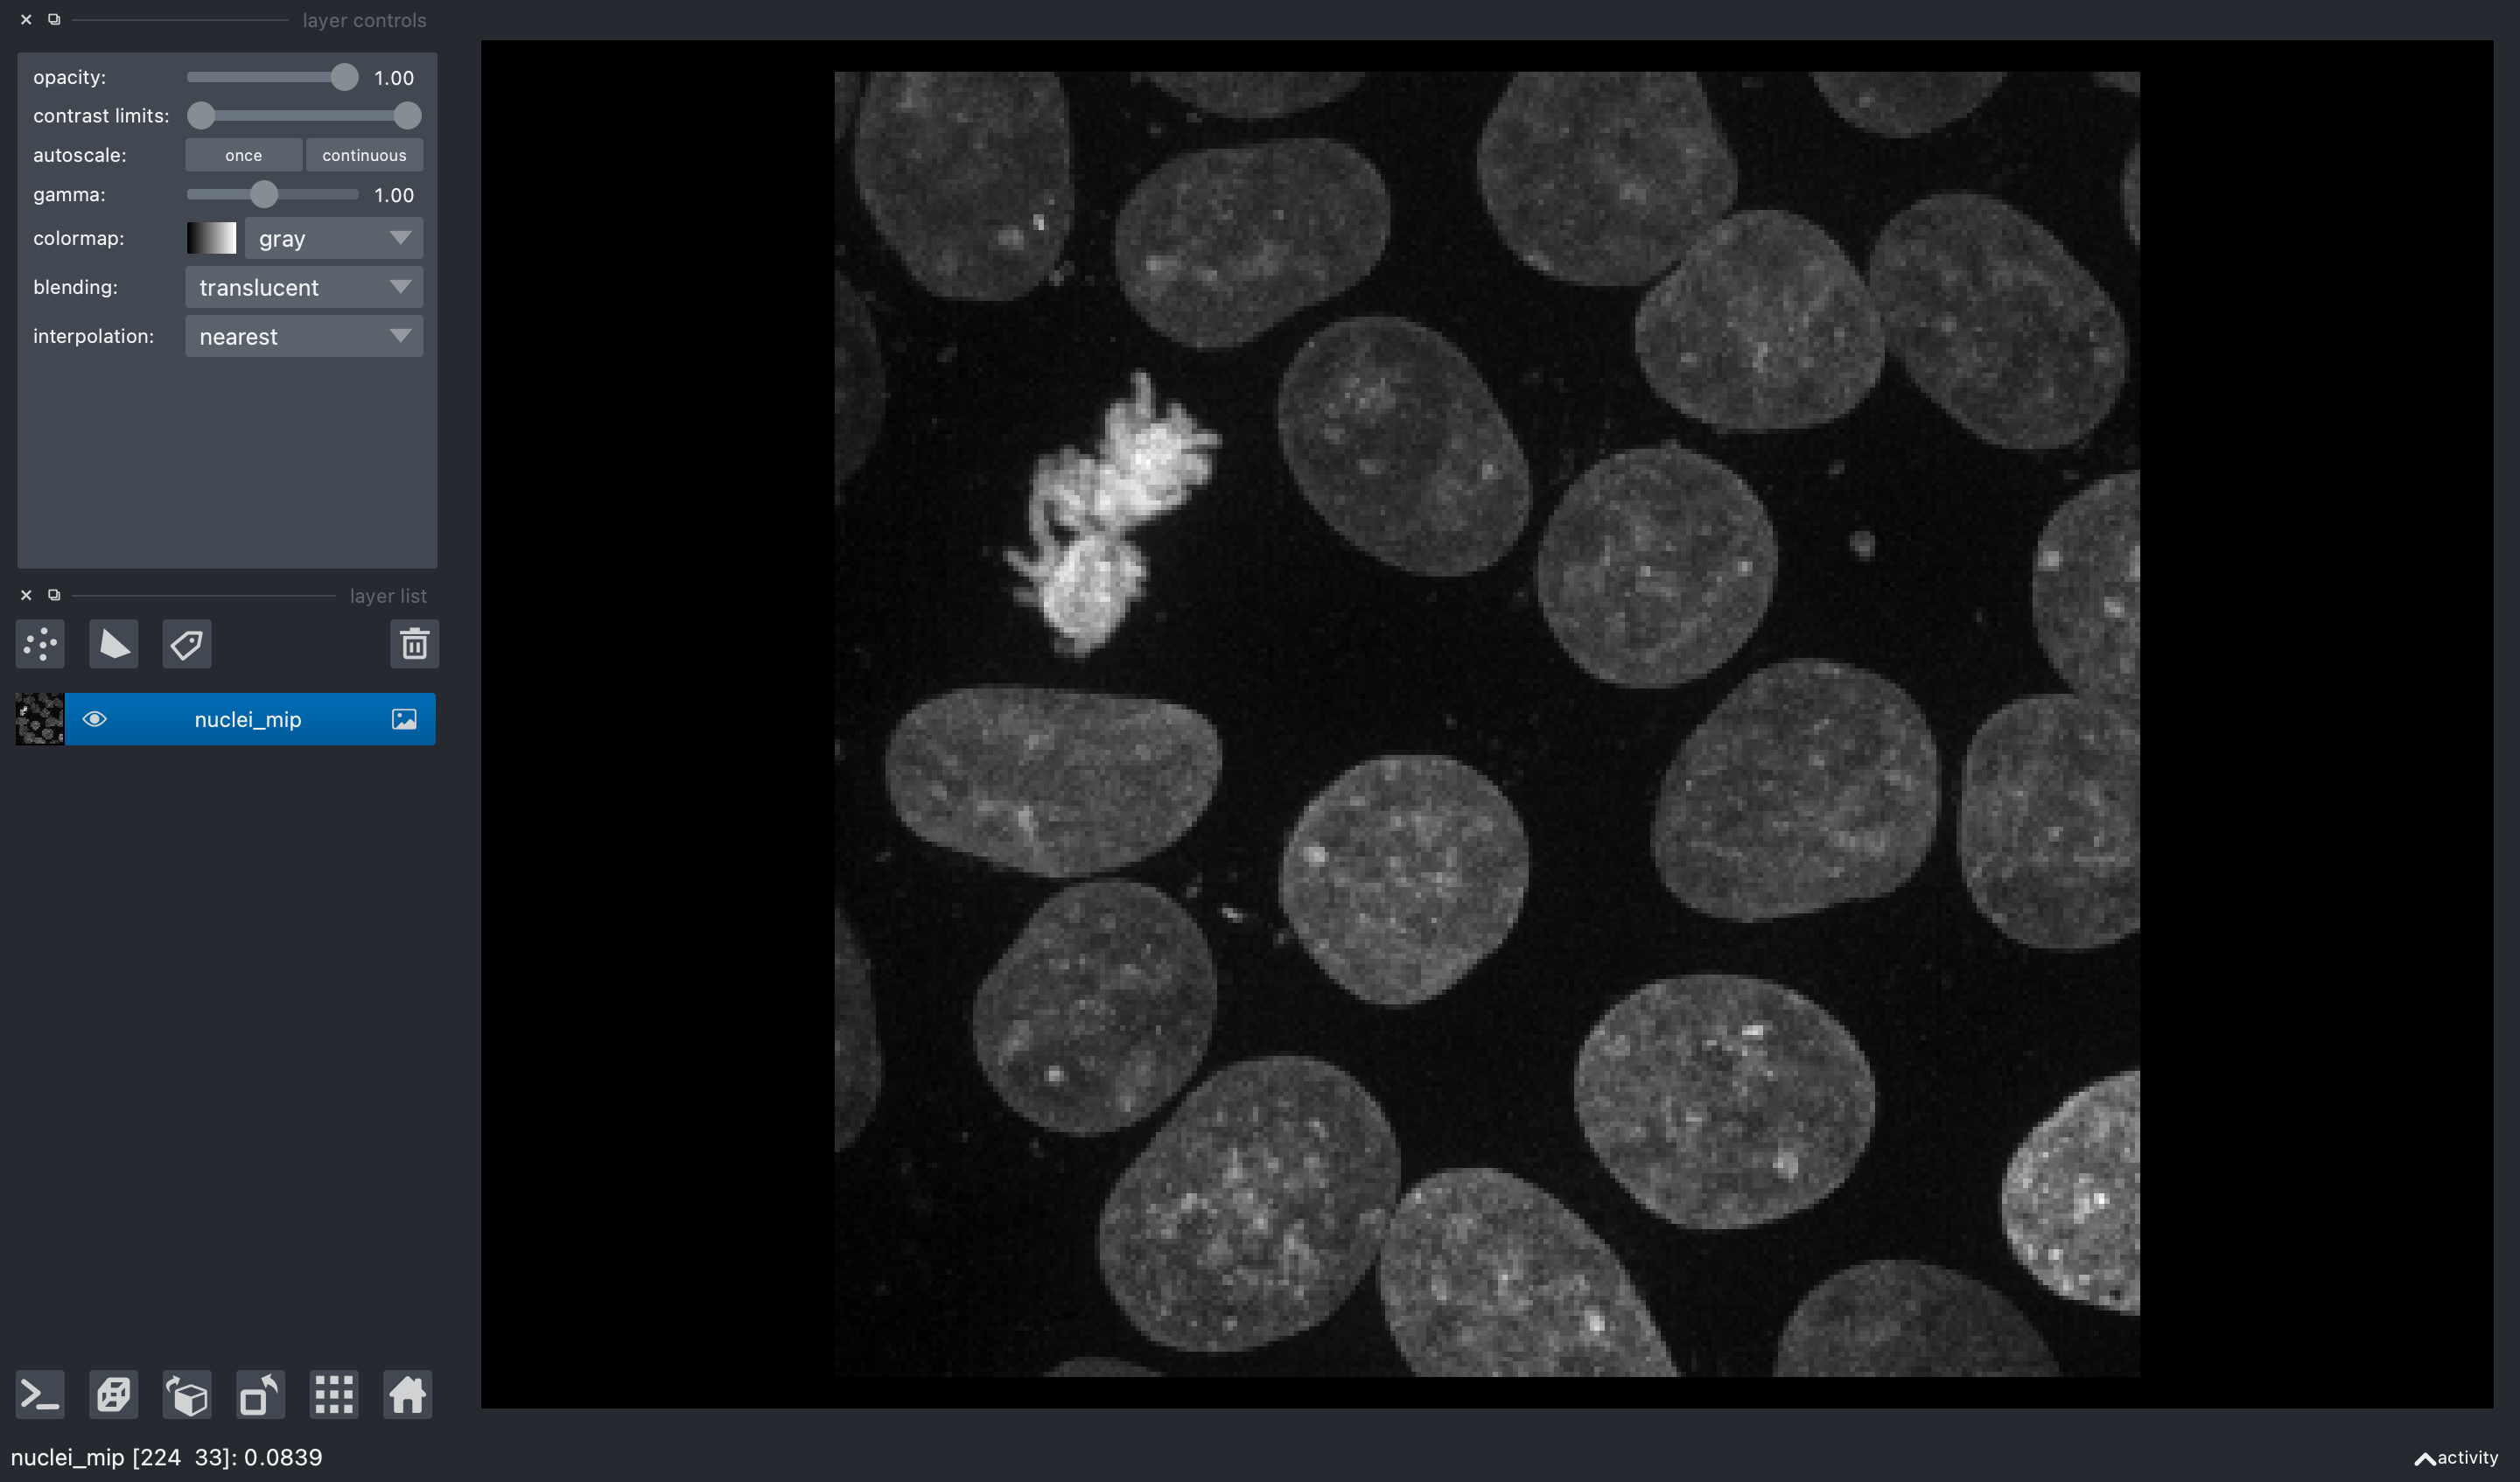

In [4]:
nbscreenshot(viewer)

## Visualizing image filtering results

One common task in image processing in **image filtering** which can be used to denoise an image or detect edges or other features.

We can use **napari** to visualize the results of some of the image filters that come with the **scikit-image** library.

In [5]:
# Import scikit-image's filtering module
from skimage import filters

In [6]:
viewer.add_image(filters.sobel_h(nuclei_mip), name='Horizontal Sobel')
viewer.add_image(filters.sobel_v(nuclei_mip), name='Vertical Sobel')
viewer.add_image(filters.roberts(nuclei_mip), name='Roberts')
viewer.add_image(filters.prewitt(nuclei_mip), name='Prewitt')
viewer.add_image(filters.scharr(nuclei_mip), name='Scharr')

<Image layer 'Scharr' at 0x7f9c09407820>

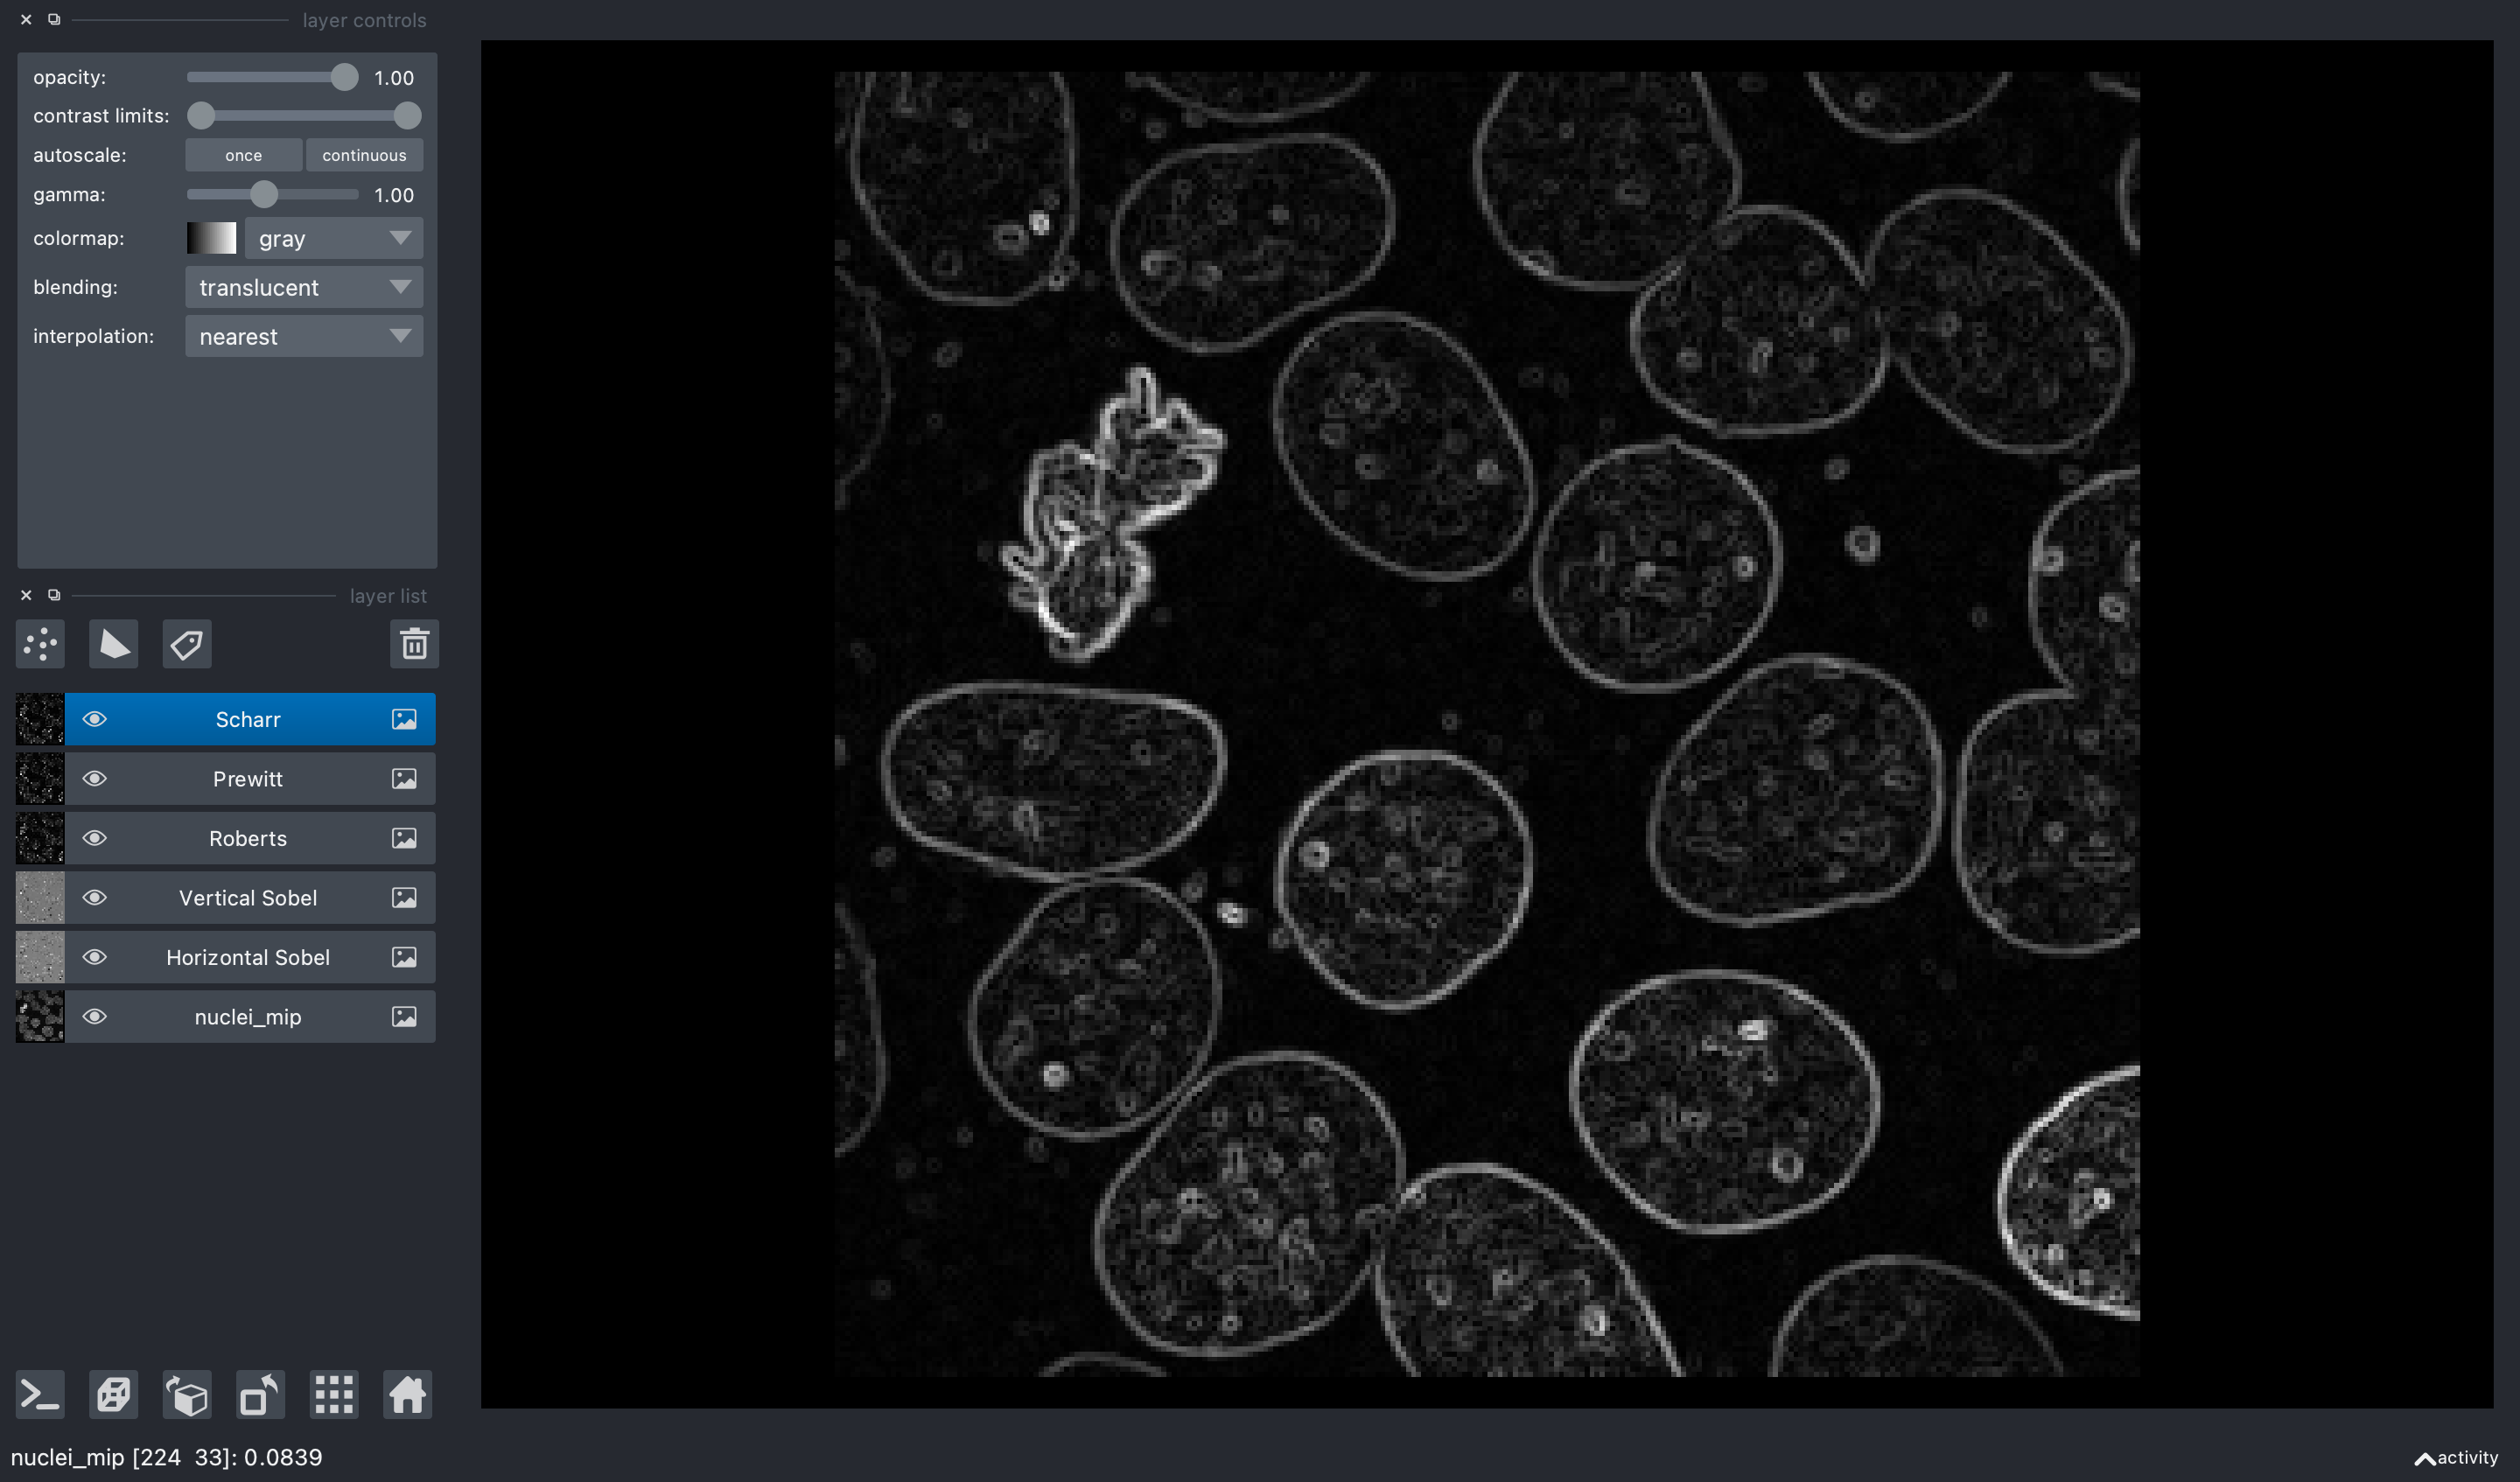

In [7]:
nbscreenshot(viewer)

In [8]:
# Remove all filter layers
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

## Interactive segmentation
Let's now perform an interactive segmentation of the nuclei using processing utilities from scikit-image.

In [9]:
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import segmentation
from scipy import ndimage
import numpy as np

First let's try and seperate background from foreground using a threhold. Here we'll use an automatically calculated threshold.

In [10]:
foreground = nuclei_mip >= filters.threshold_li(nuclei_mip)
viewer.add_labels(foreground, name='foreground')

<Labels layer 'foreground' at 0x7f9bf87b0e50>

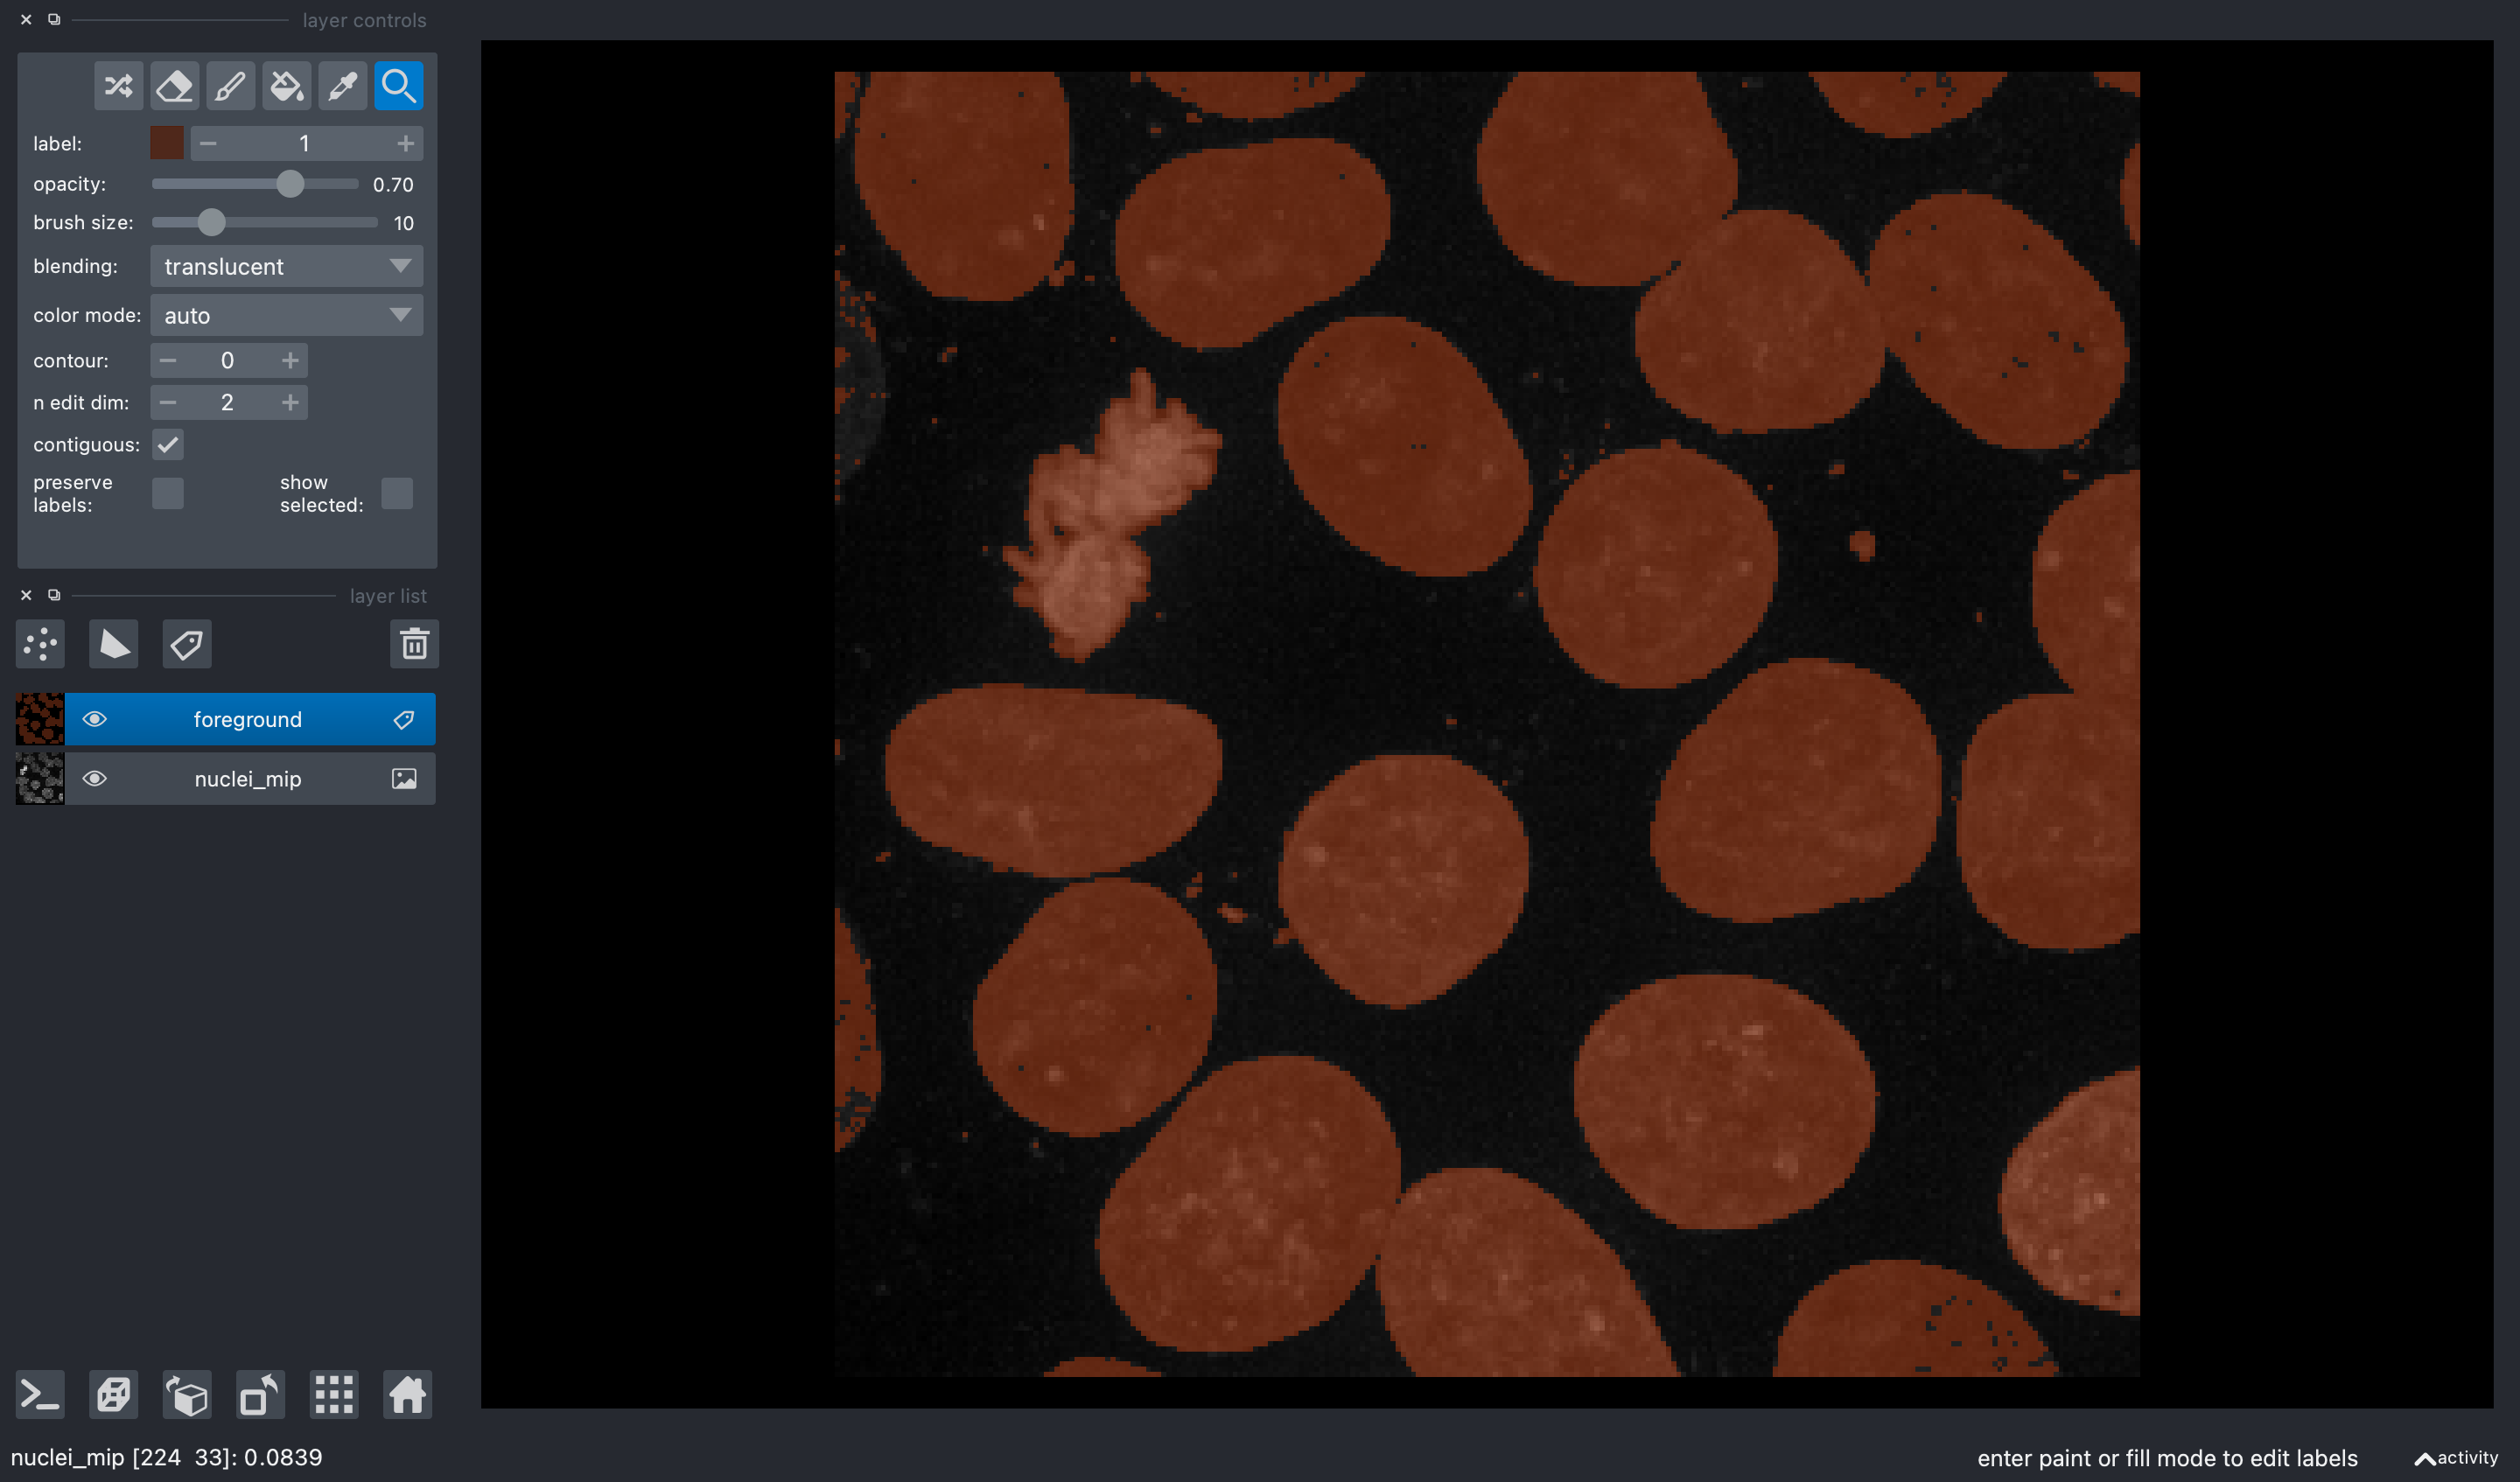

In [11]:
nbscreenshot(viewer)

Notice the debris located outside the nuclei and some of the holes located inside the nuclei. We will remove the debris by filtering out small objects, and fill the holes using a hole filling algorithm. We can update the data in the viewer in place.

In [12]:
foreground_processed = morphology.remove_small_holes(foreground, 60)
foreground_processed = morphology.remove_small_objects(foreground_processed, min_size=50)

viewer.layers['foreground'].data = foreground_processed

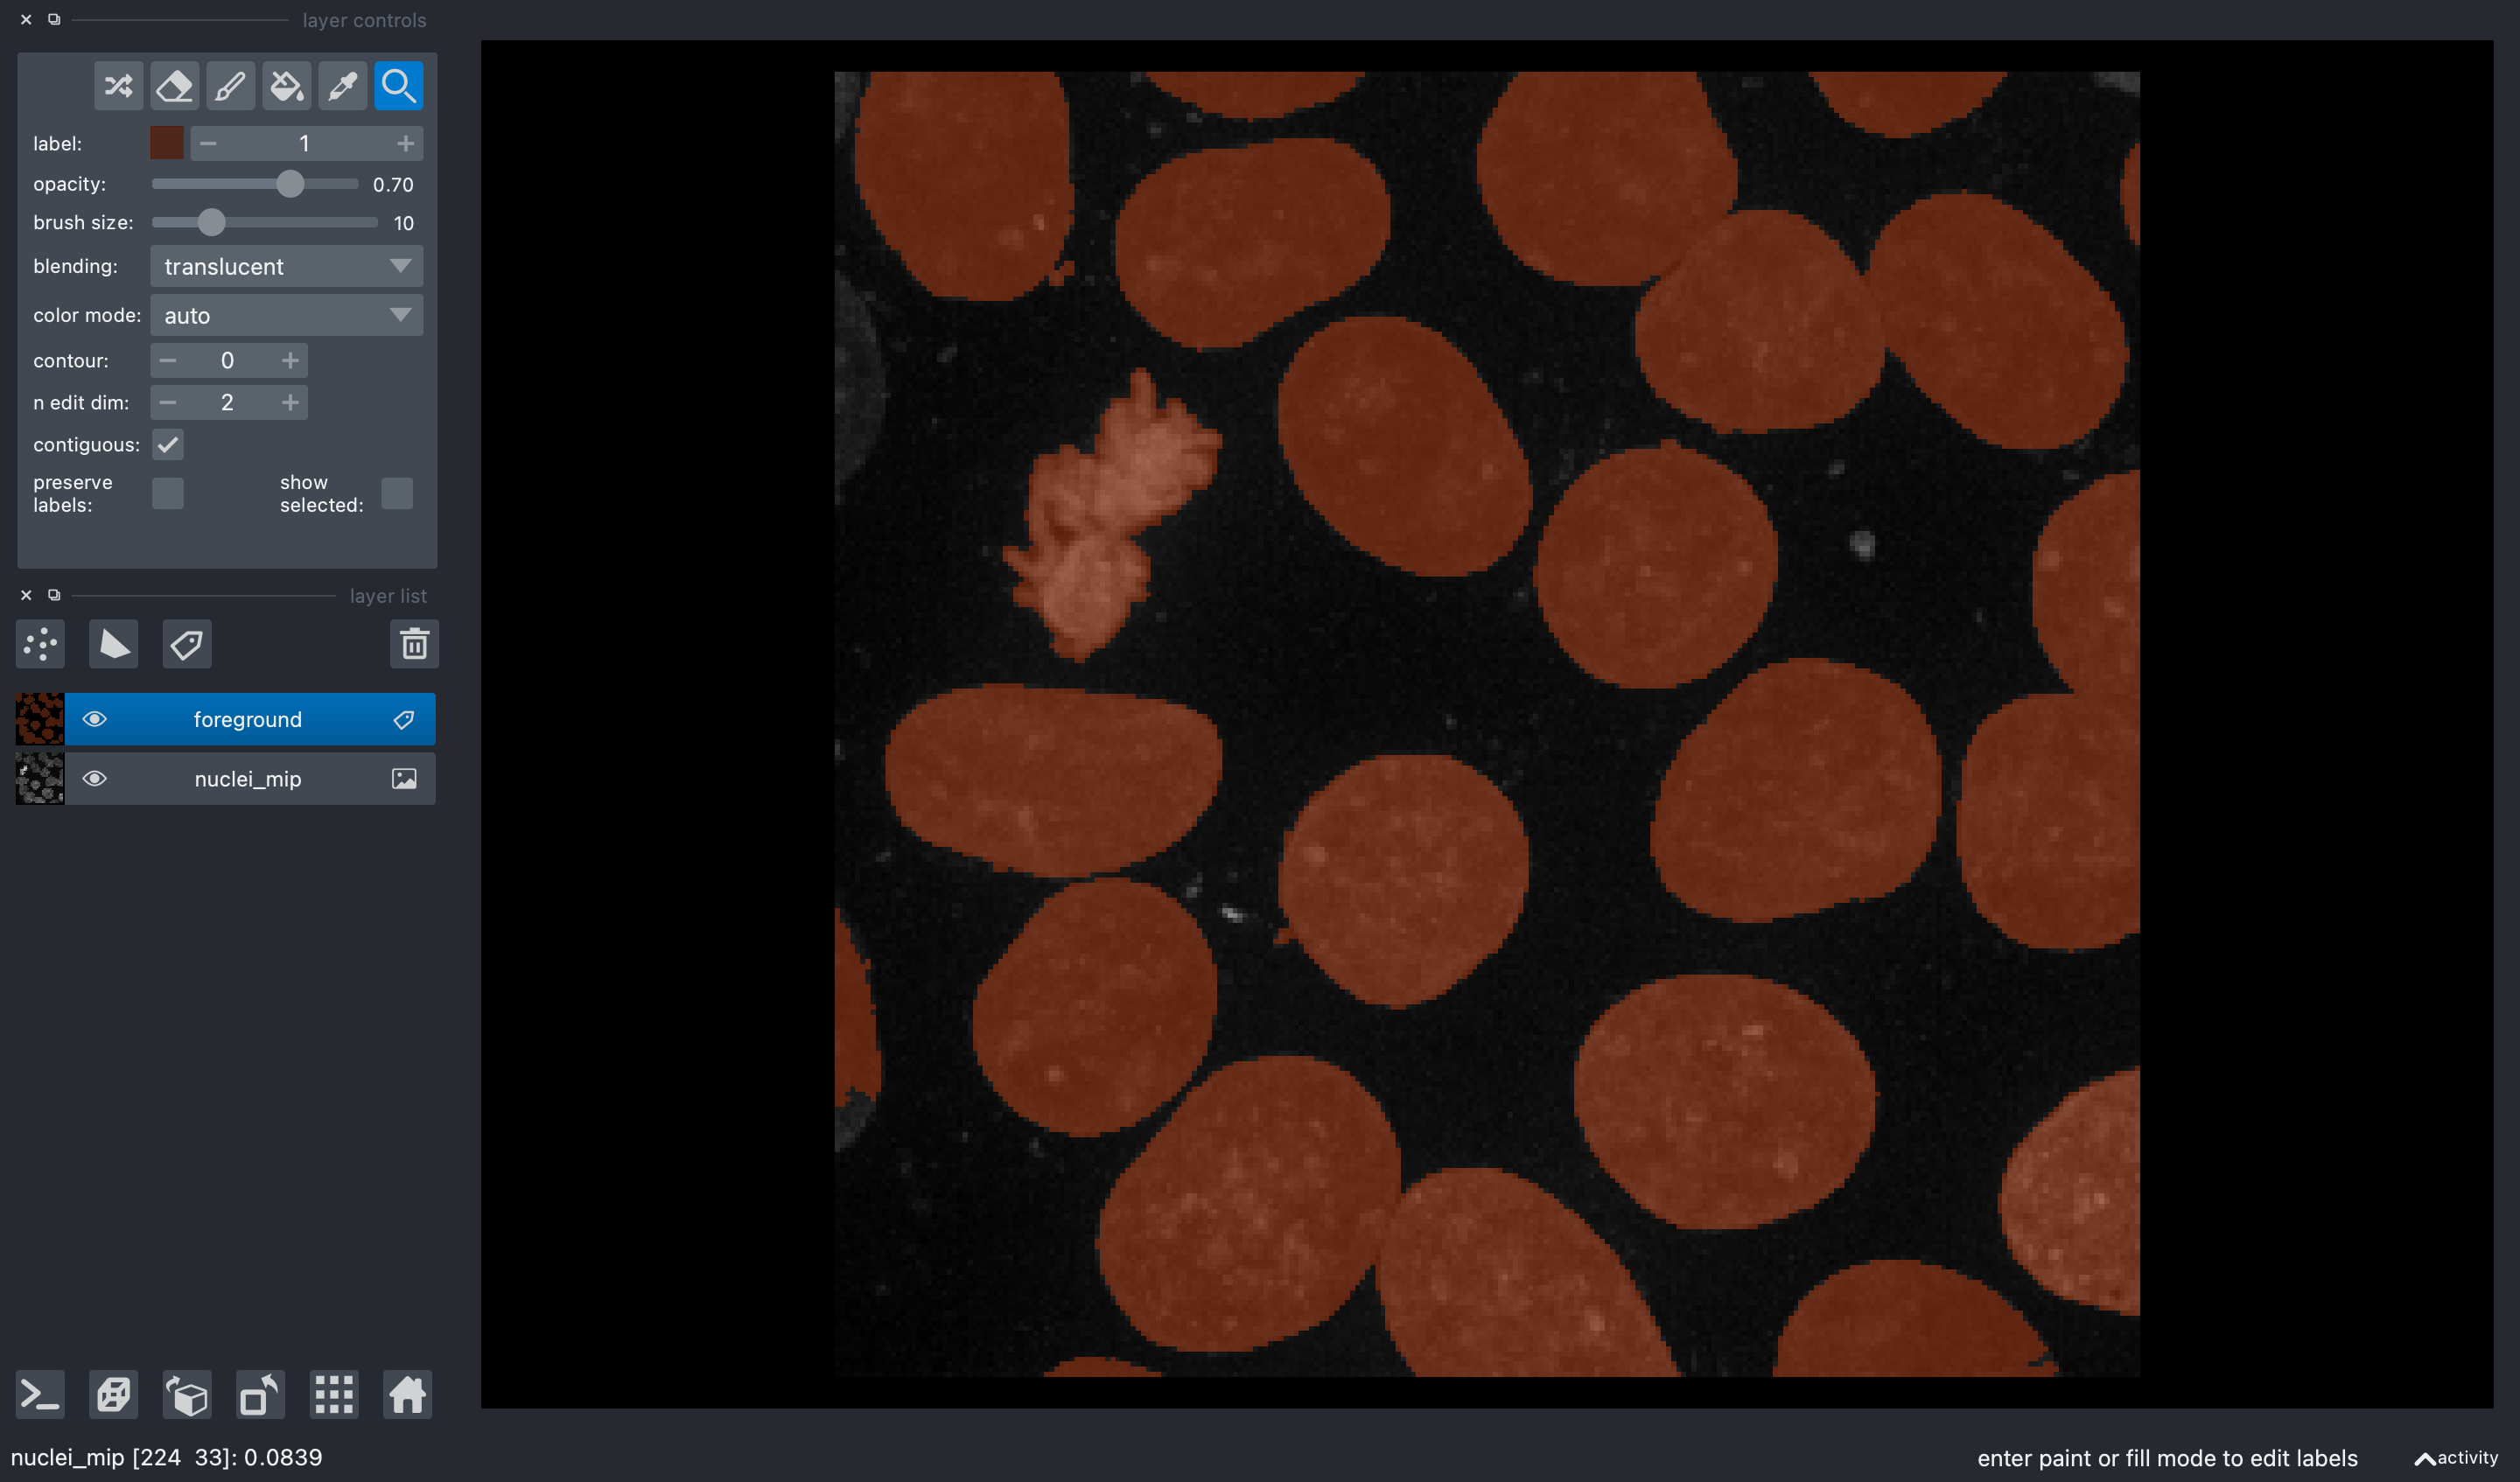

In [13]:
nbscreenshot(viewer)

We will now convert this binary mask into an **instance segmentation** where each nuclei is assigned a unique label.

We will do this using a **marker controlled watershed** approach. The first step in this procedure is to calculate a distance transform on the binary mask as follows.

In [14]:
distance = ndimage.distance_transform_edt(foreground_processed)
viewer.add_image(distance)

<Image layer 'distance' at 0x7f9c096152e0>

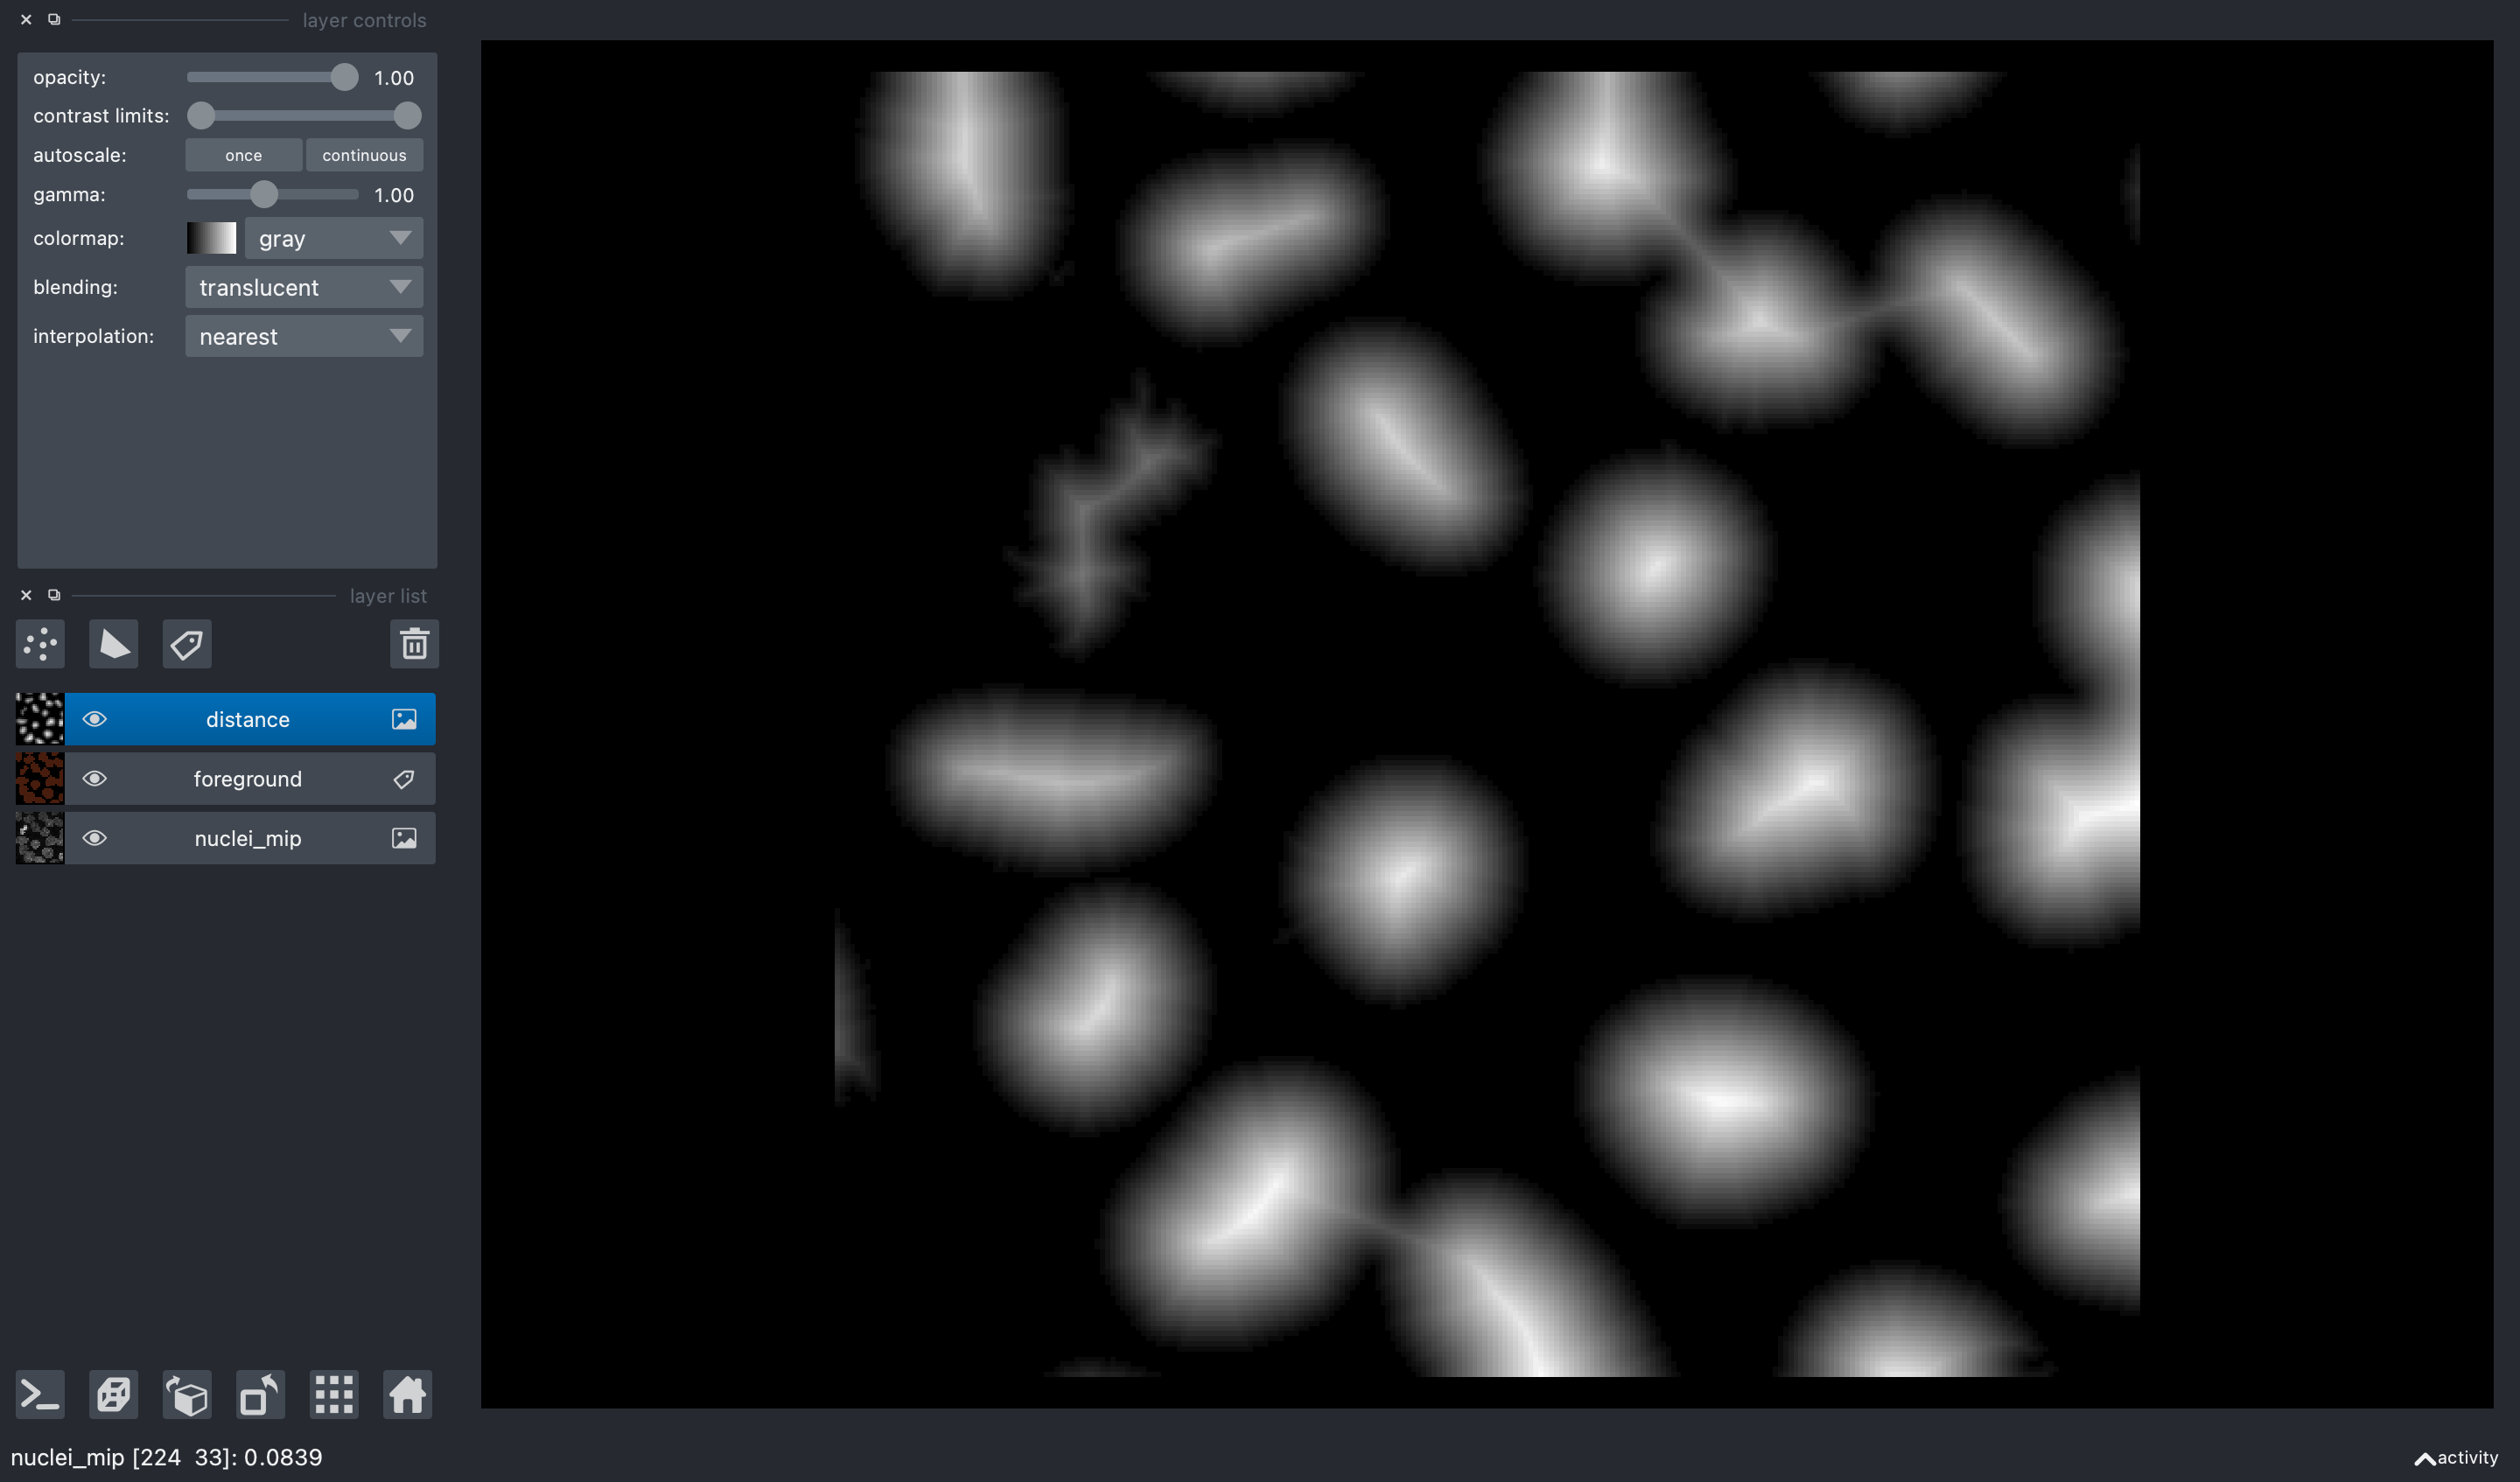

In [15]:
nbscreenshot(viewer)

We'll actually want to smooth the distance transform to avoid over segmentation artifacts. We can do this on the data in the viewer in place.

In [16]:
smoothed_distance = filters.gaussian(distance, 10)
viewer.layers['distance'].data = smoothed_distance

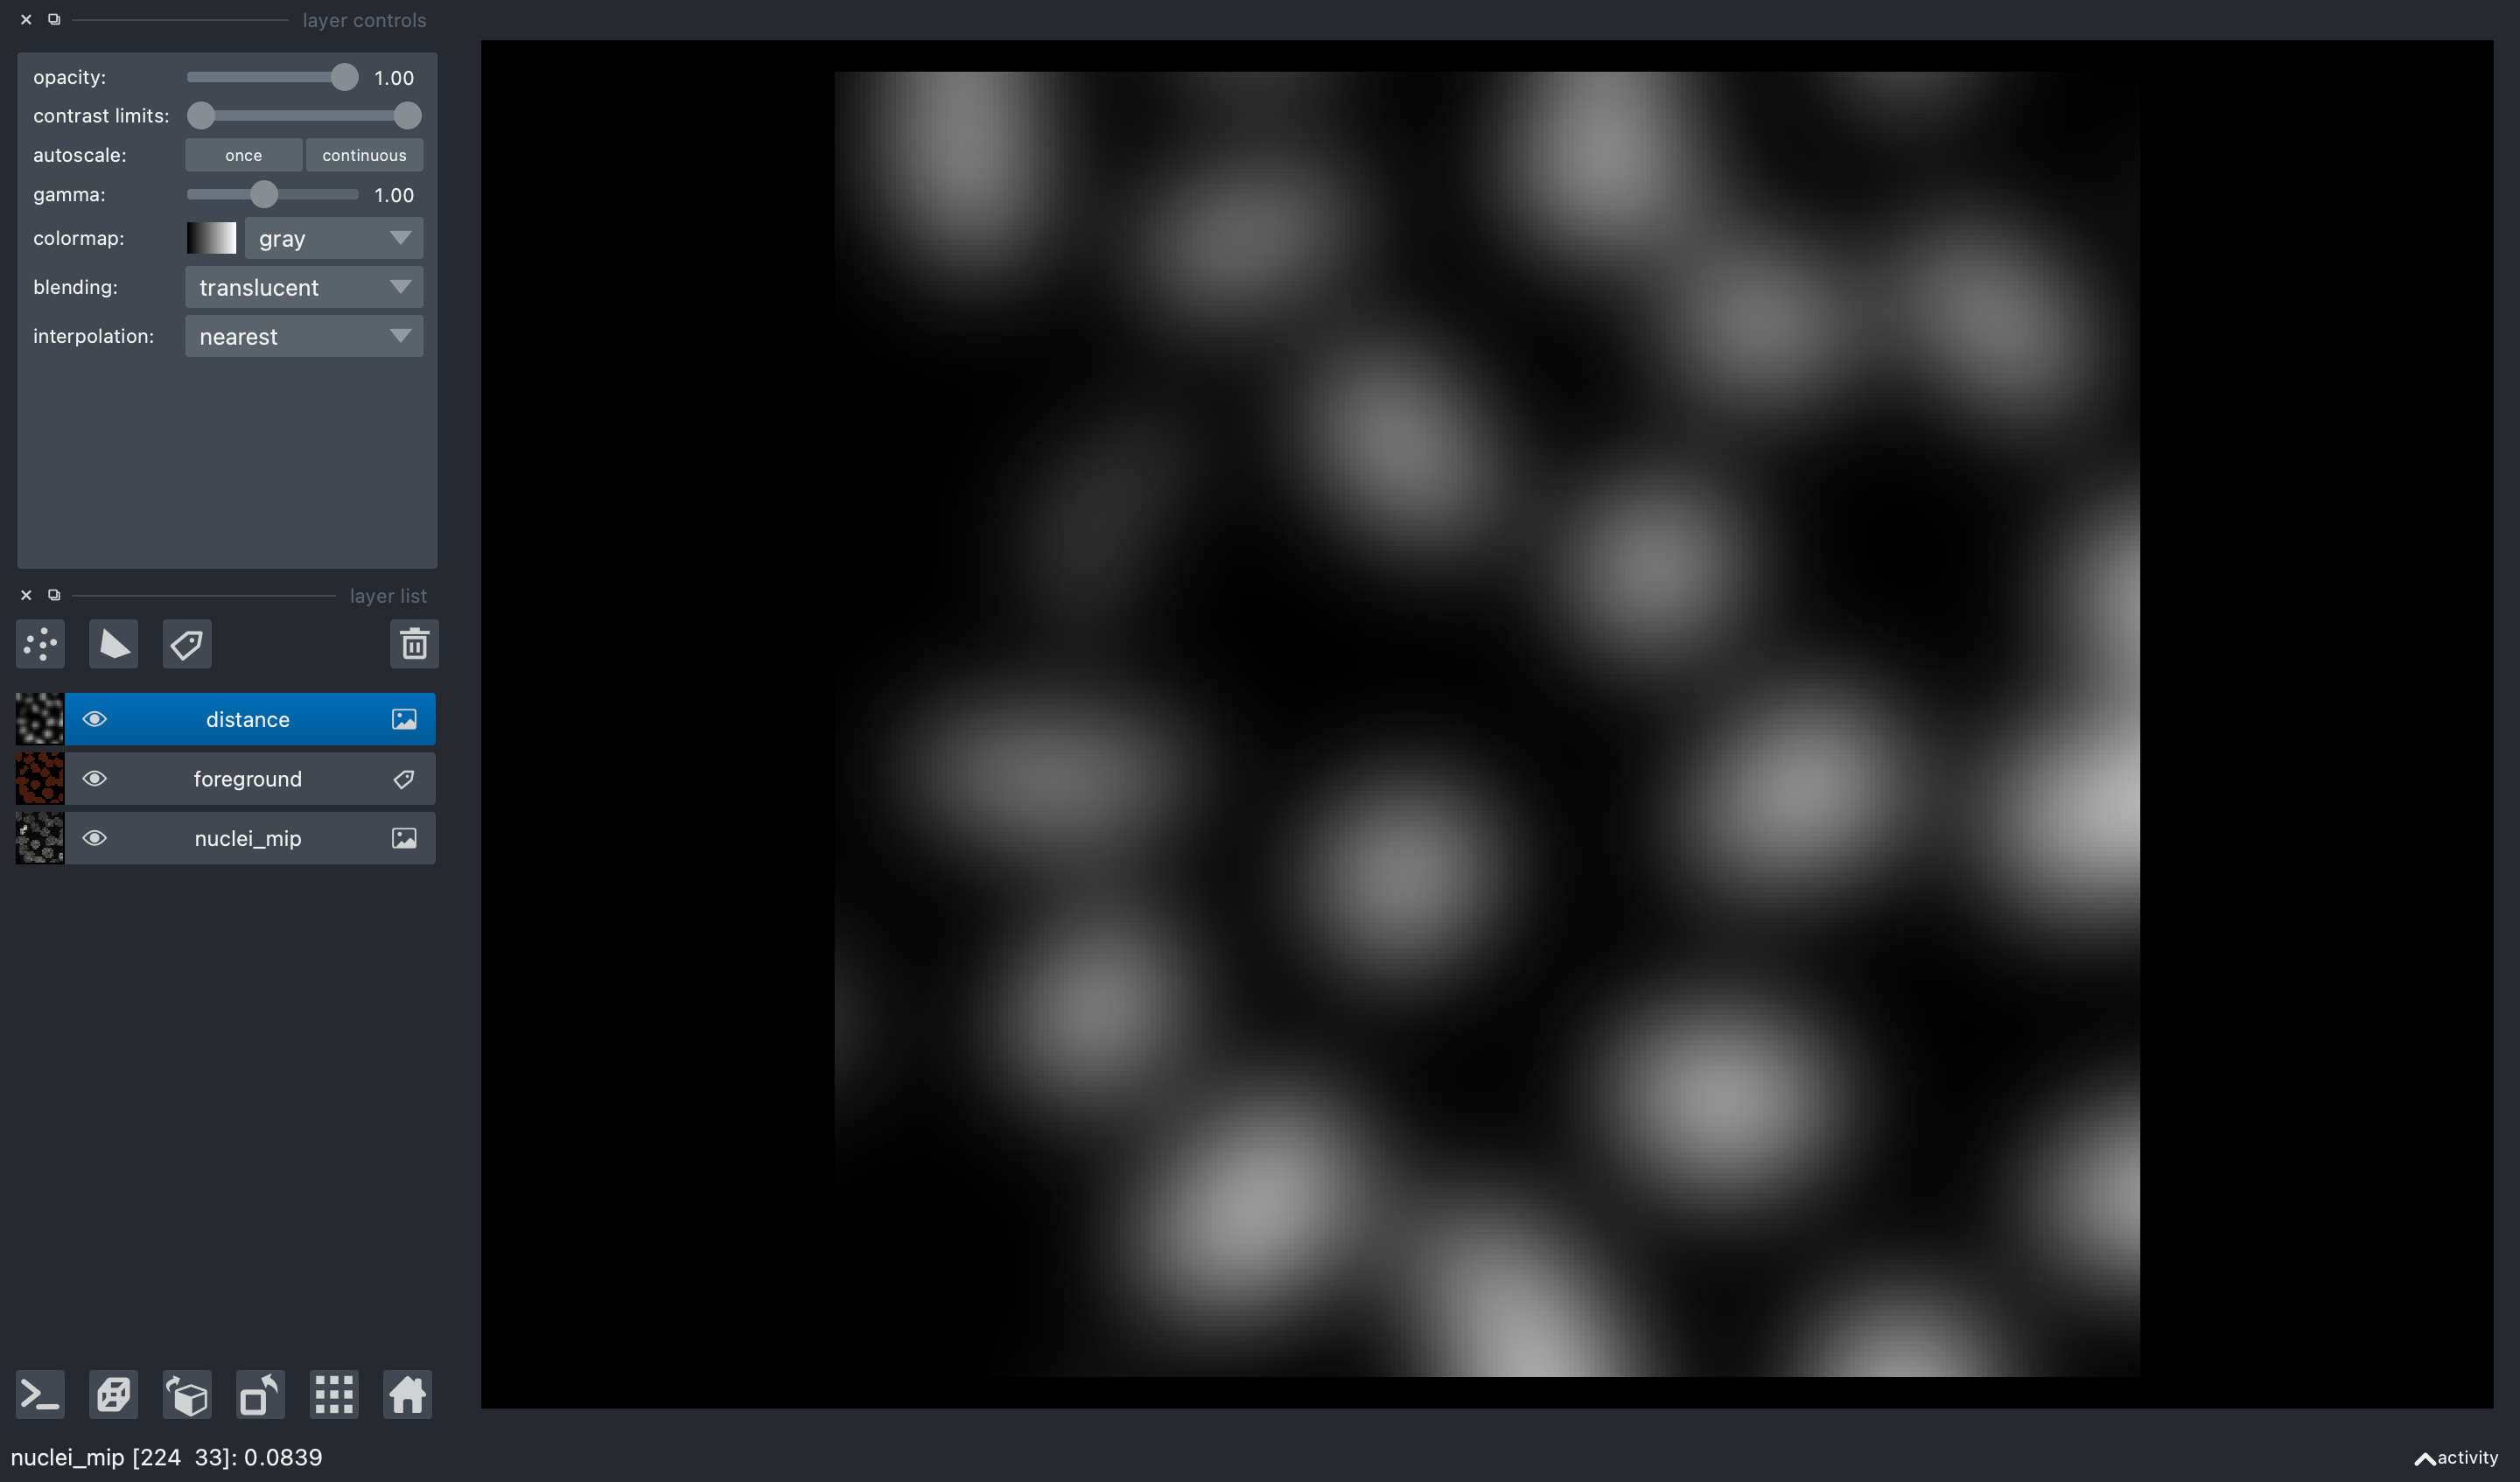

In [17]:
nbscreenshot(viewer)

Now we can try and identify the centers of each of the nuclei by finding peaks of the distance transform

In [18]:
peak_local_max = feature.peak_local_max(
    smoothed_distance,
    footprint=np.ones((7, 7), dtype=bool),
    indices=False,
    labels=measure.label(foreground_processed)
)
peaks = np.nonzero(peak_local_max)

<ipython-input-18-13be72896593>:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_local_max = feature.peak_local_max(


In [19]:
viewer.add_points(np.array(peaks).T, name='peaks', size=5, face_color='red');

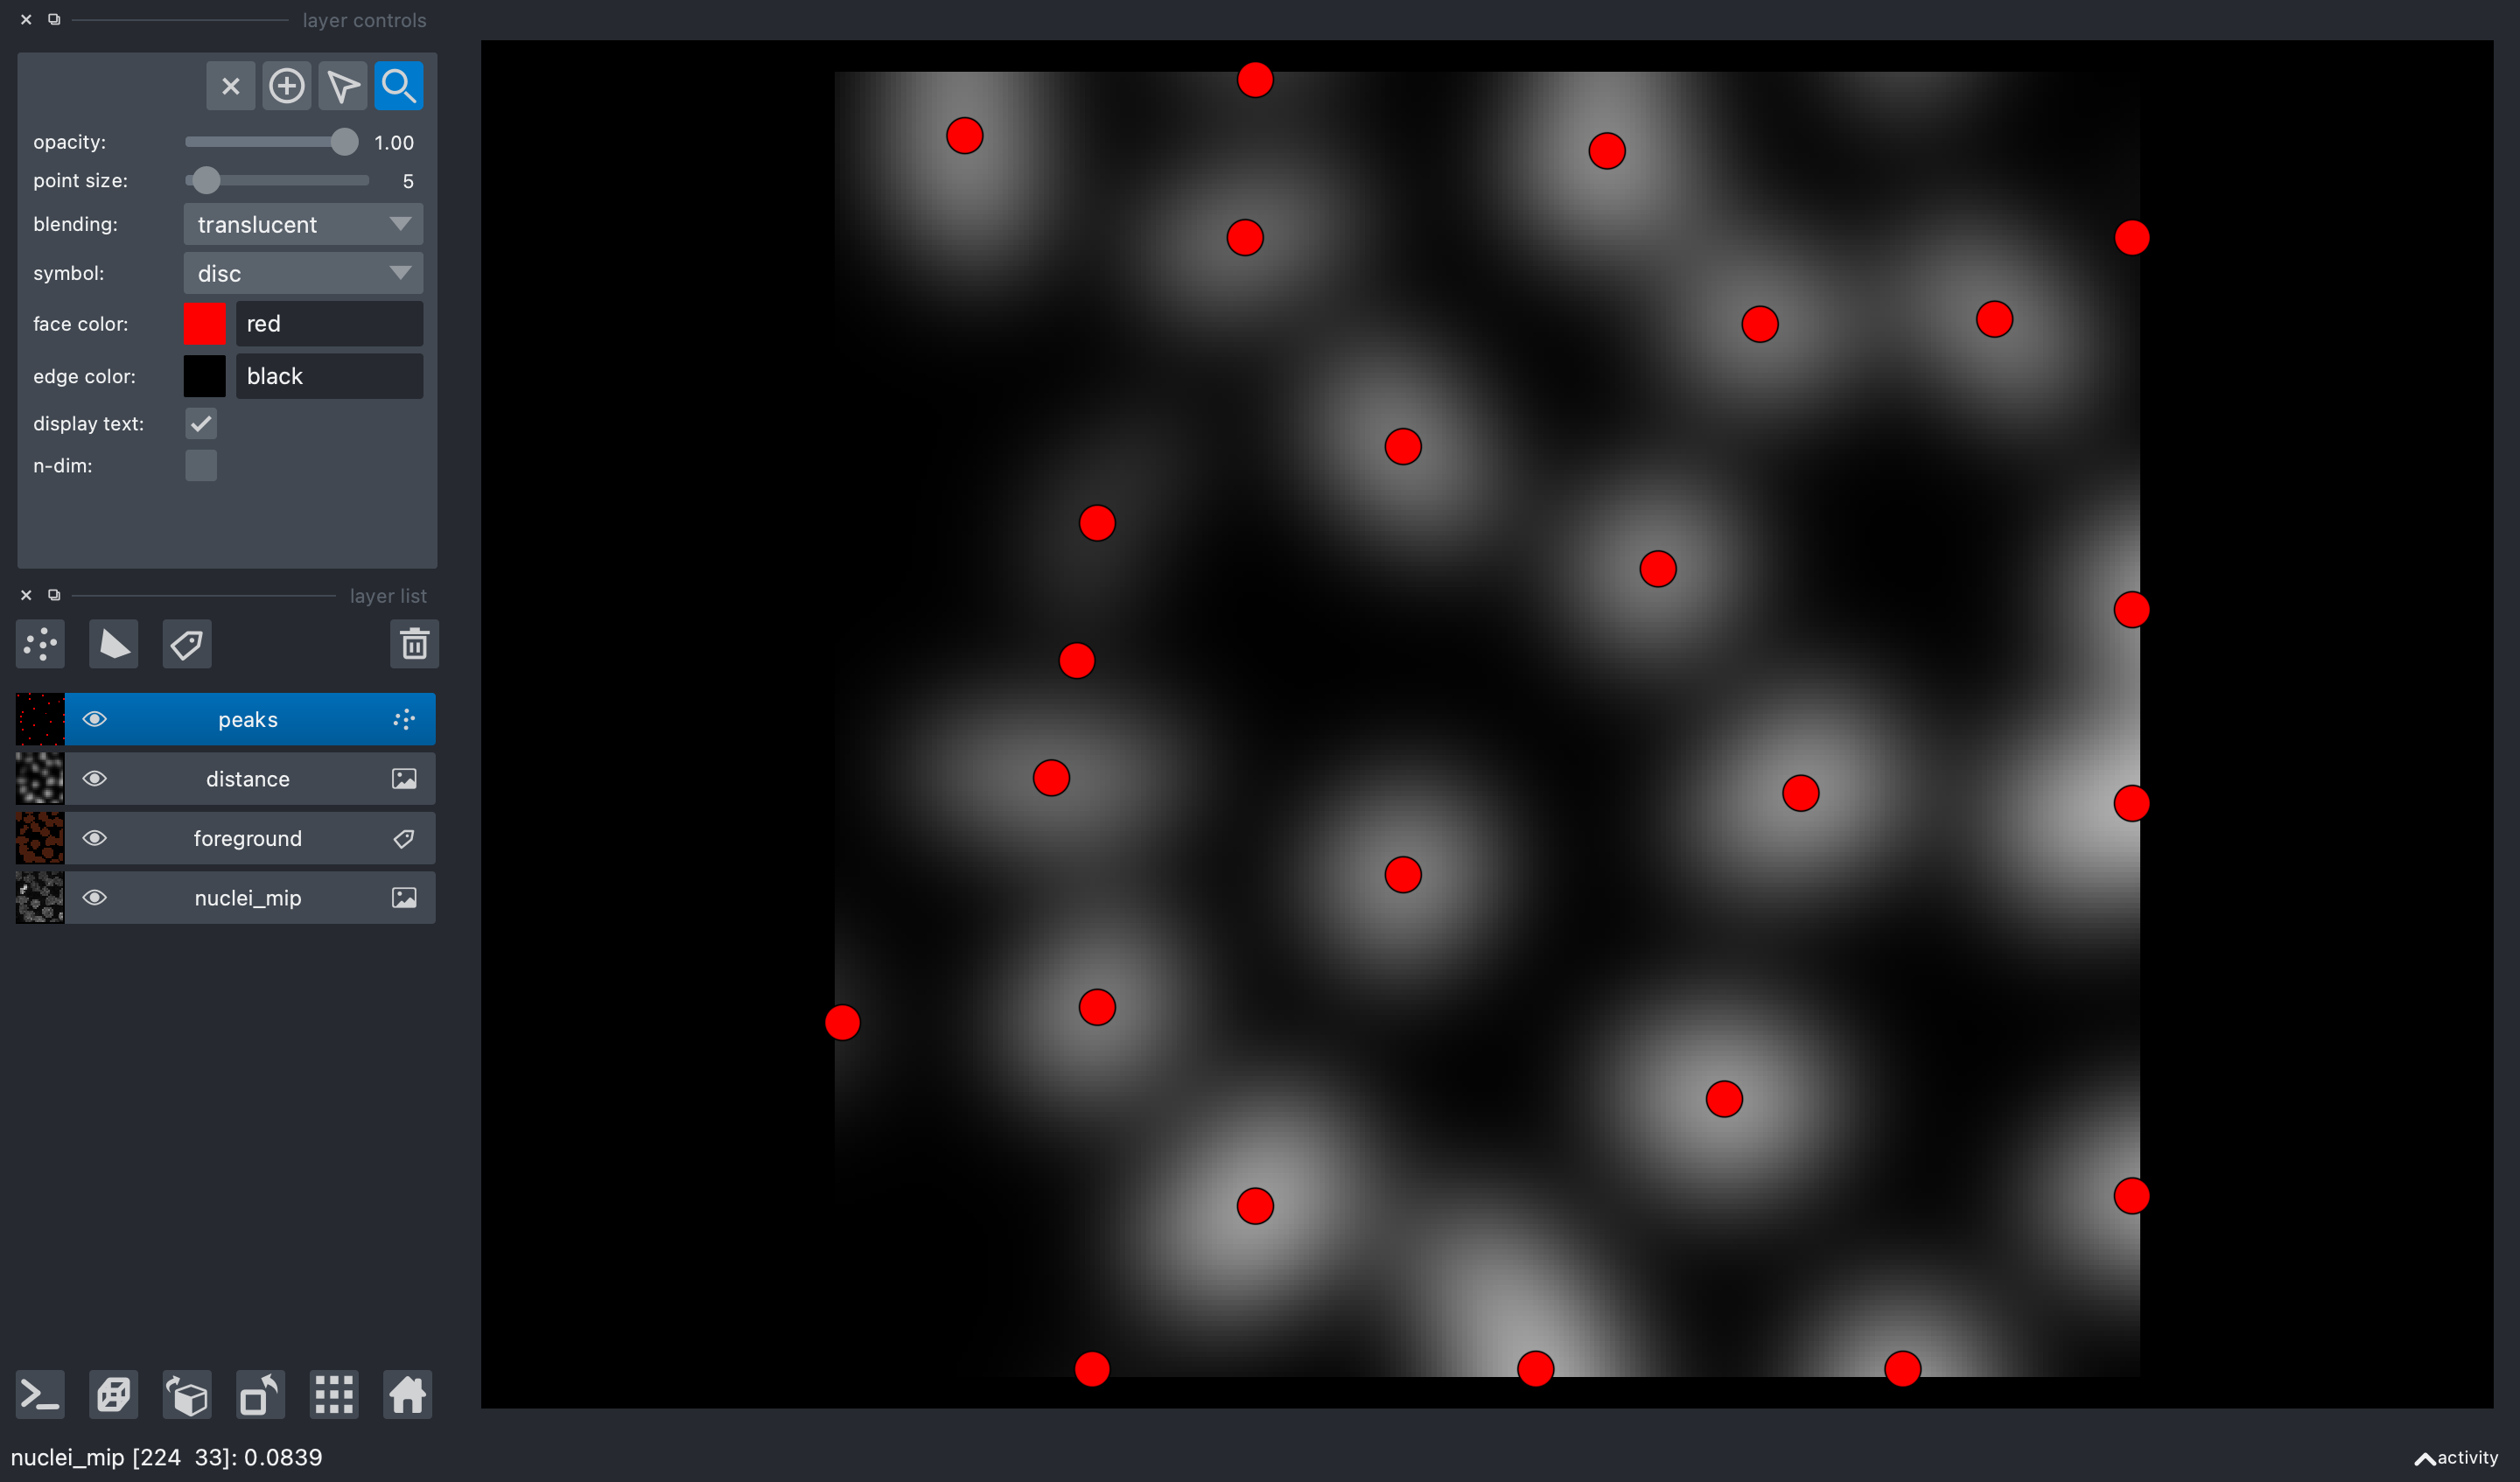

In [20]:
nbscreenshot(viewer)

We can now remove any of the points that don't correspond to nuclei centers or add any new ones using the GUI.

In [21]:
viewer.layers['peaks'].selected_data = {11}
viewer.layers['peaks'].remove_selected()

Based on those peaks we can now seed the watershed algorithm which will find the nuclei boundaries.

In [22]:
new_peaks = np.round(viewer.layers['peaks'].data).astype(int).T
seeds = np.zeros(nuclei_mip.shape, dtype=bool)
seeds[(new_peaks[0], new_peaks[1])] = 1

markers = measure.label(seeds)
nuclei_segmentation = segmentation.watershed(
    -smoothed_distance, 
    markers, 
    mask=foreground_processed
)

viewer.add_labels(nuclei_segmentation)

<Labels layer 'nuclei_segmentation' at 0x7f9c1995c3a0>

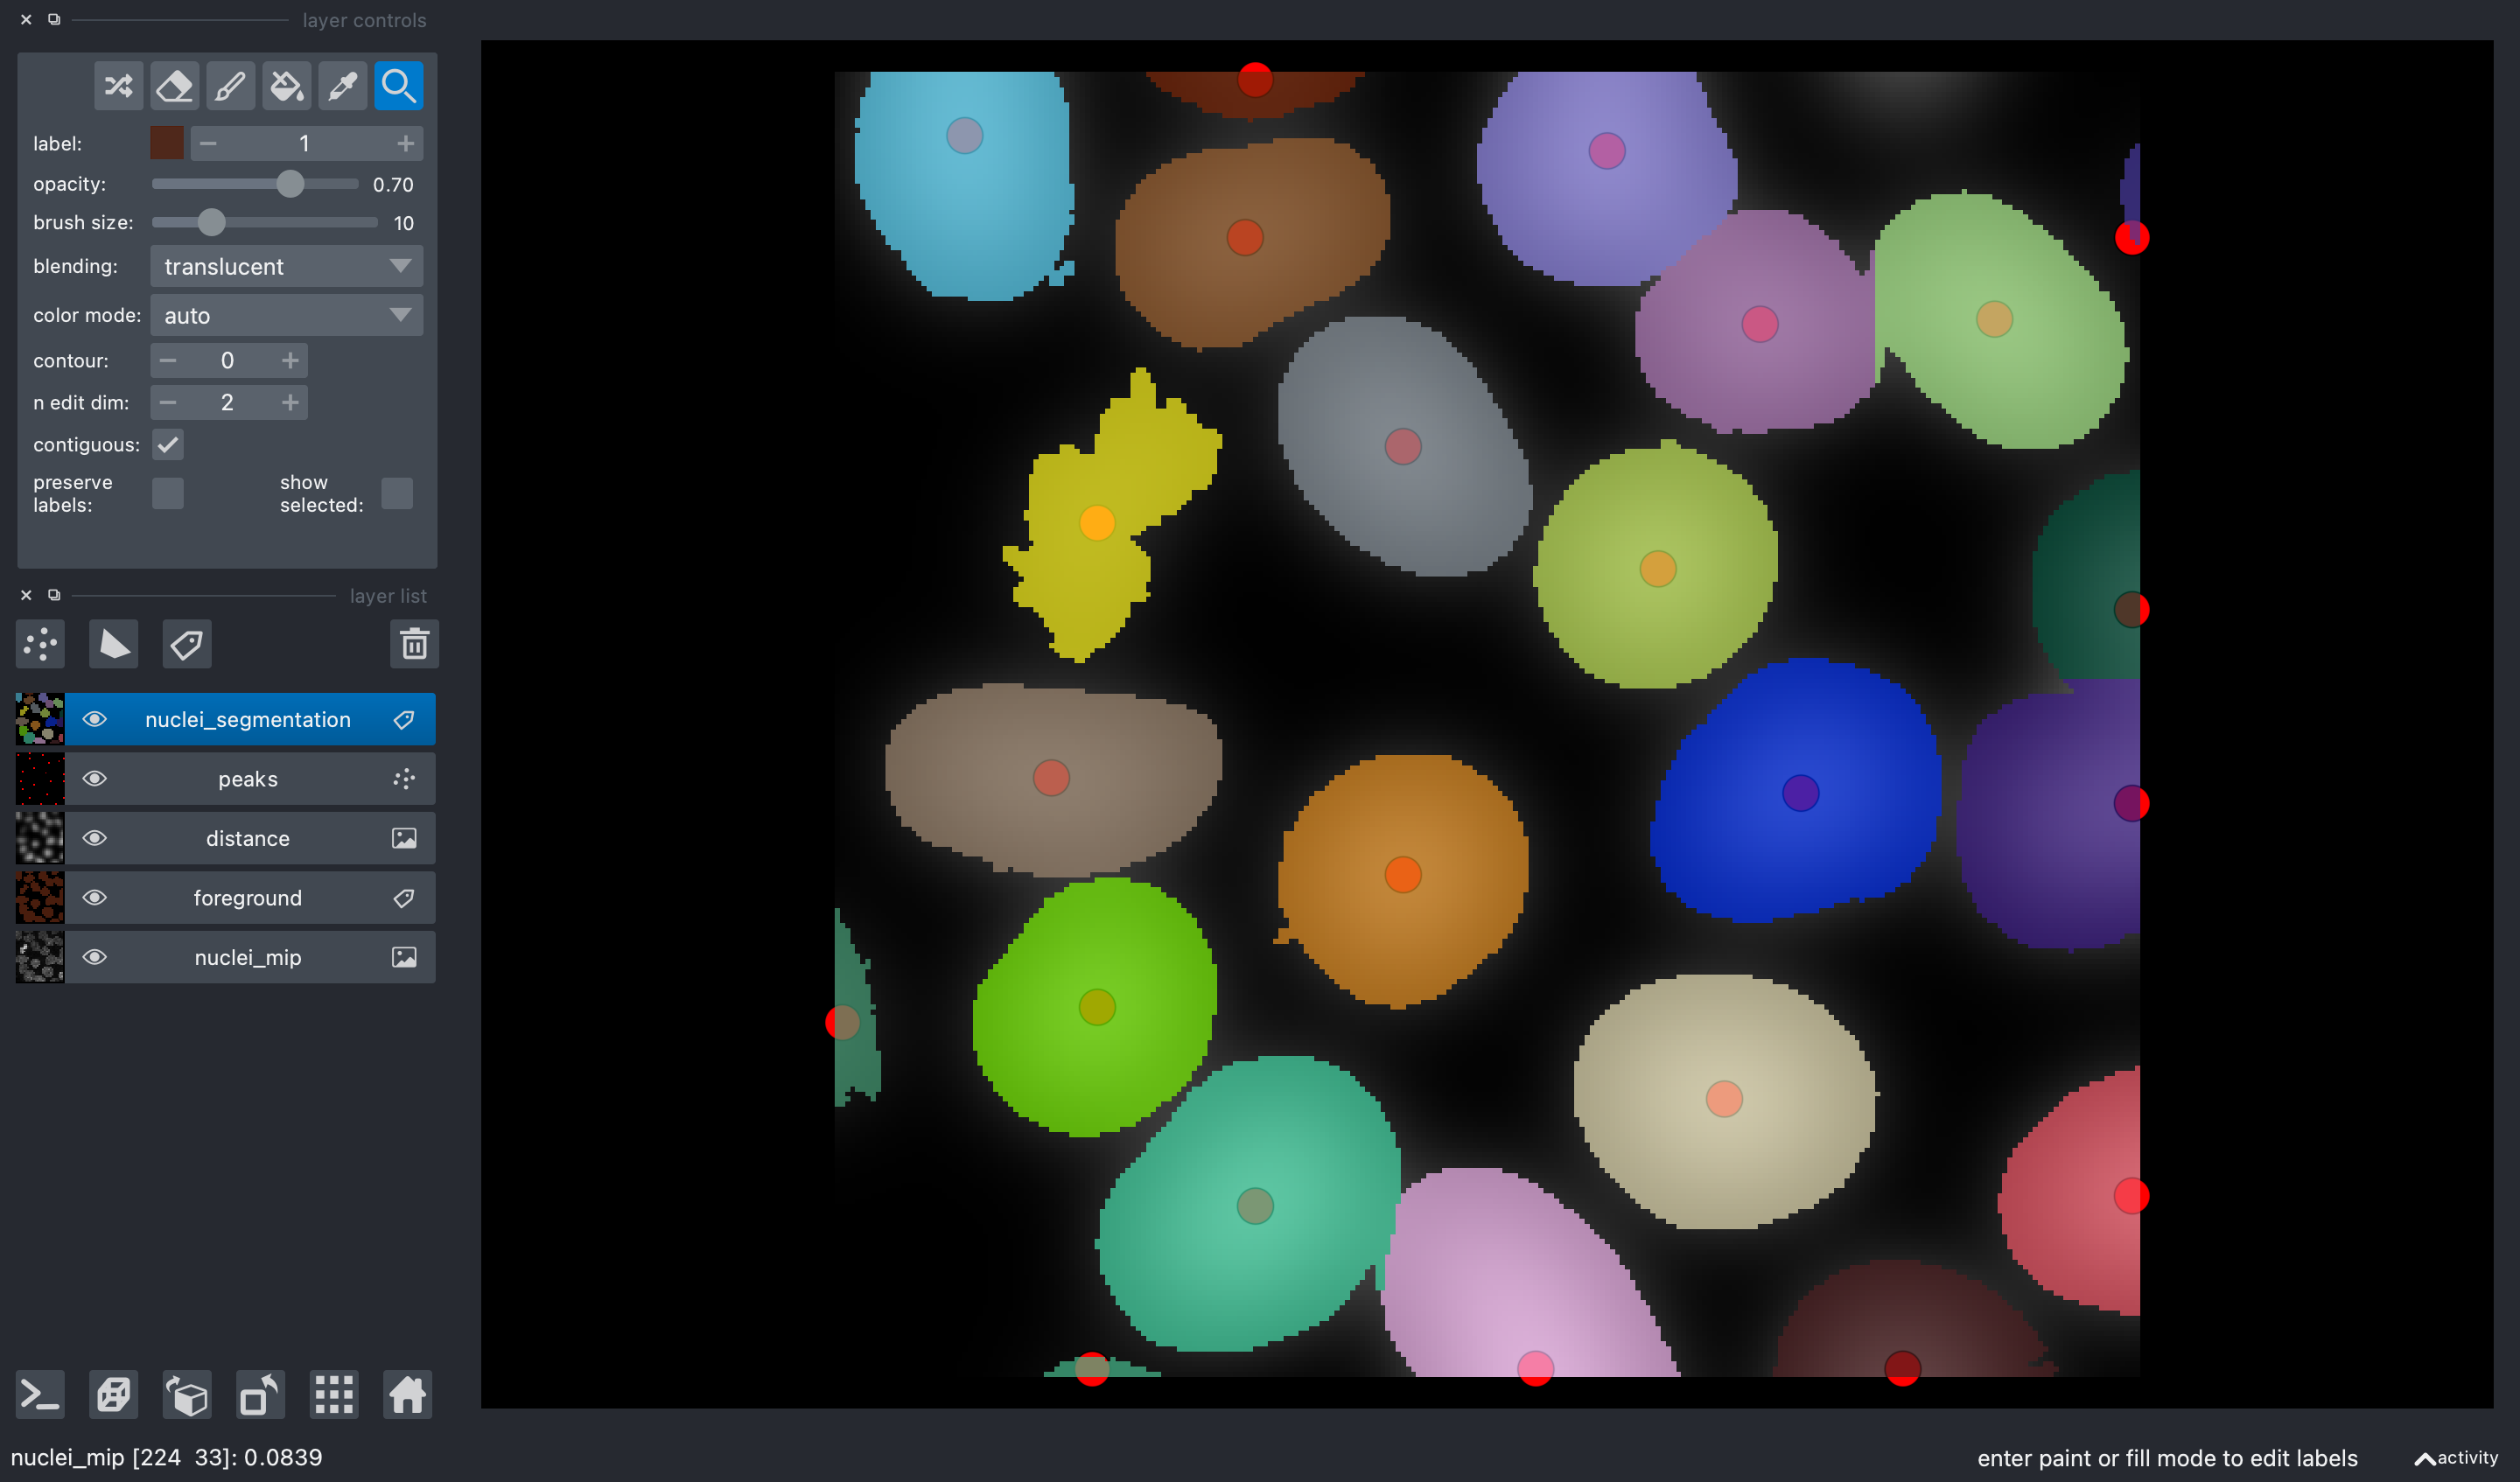

In [23]:
nbscreenshot(viewer)

We can now save our segmentation using our builtin save method.

In [24]:
viewer.layers['nuclei_segmentation'].save('nuclei-automated-segmentation.tif', plugin='builtins')

['/Users/aburt/Programming/napari-workshop/napari-workshops/notebooks/nuclei-automated-segmentation.tif']

## Interactive thresholding with a custom GUI element

Interactivity can be greatly enhanced by custom GUI elements like slides and push buttons, custom mouse functions, or custom keybindings. **[napari](https://napari.org/)** can easliy be exteneded with these features, and a companion library **[magicgui](https://magicgui.readthedocs.io/en/latest/)** maintained by the napari team allows users to make extensions to the GUI without having to write any GUI code.

We'll now explore adding such interactivty to **napari**.

In [25]:
# Remove all processed layers
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

In [26]:
# Import magicgui
from magicgui import magicgui

In [27]:
from napari.types import ImageData, LabelsData

@magicgui(auto_call=True,
          percentile={"widget_type": "IntSlider", "min": 0, "max": 100})
def threshold(image: ImageData, percentile: int = 50) -> LabelsData:
    data_min = np.min(image)
    data_max = np.max(image)
    return image > data_min + percentile / 100 * (data_max - data_min)

In [28]:
viewer.window.add_dock_widget(threshold, area="right")

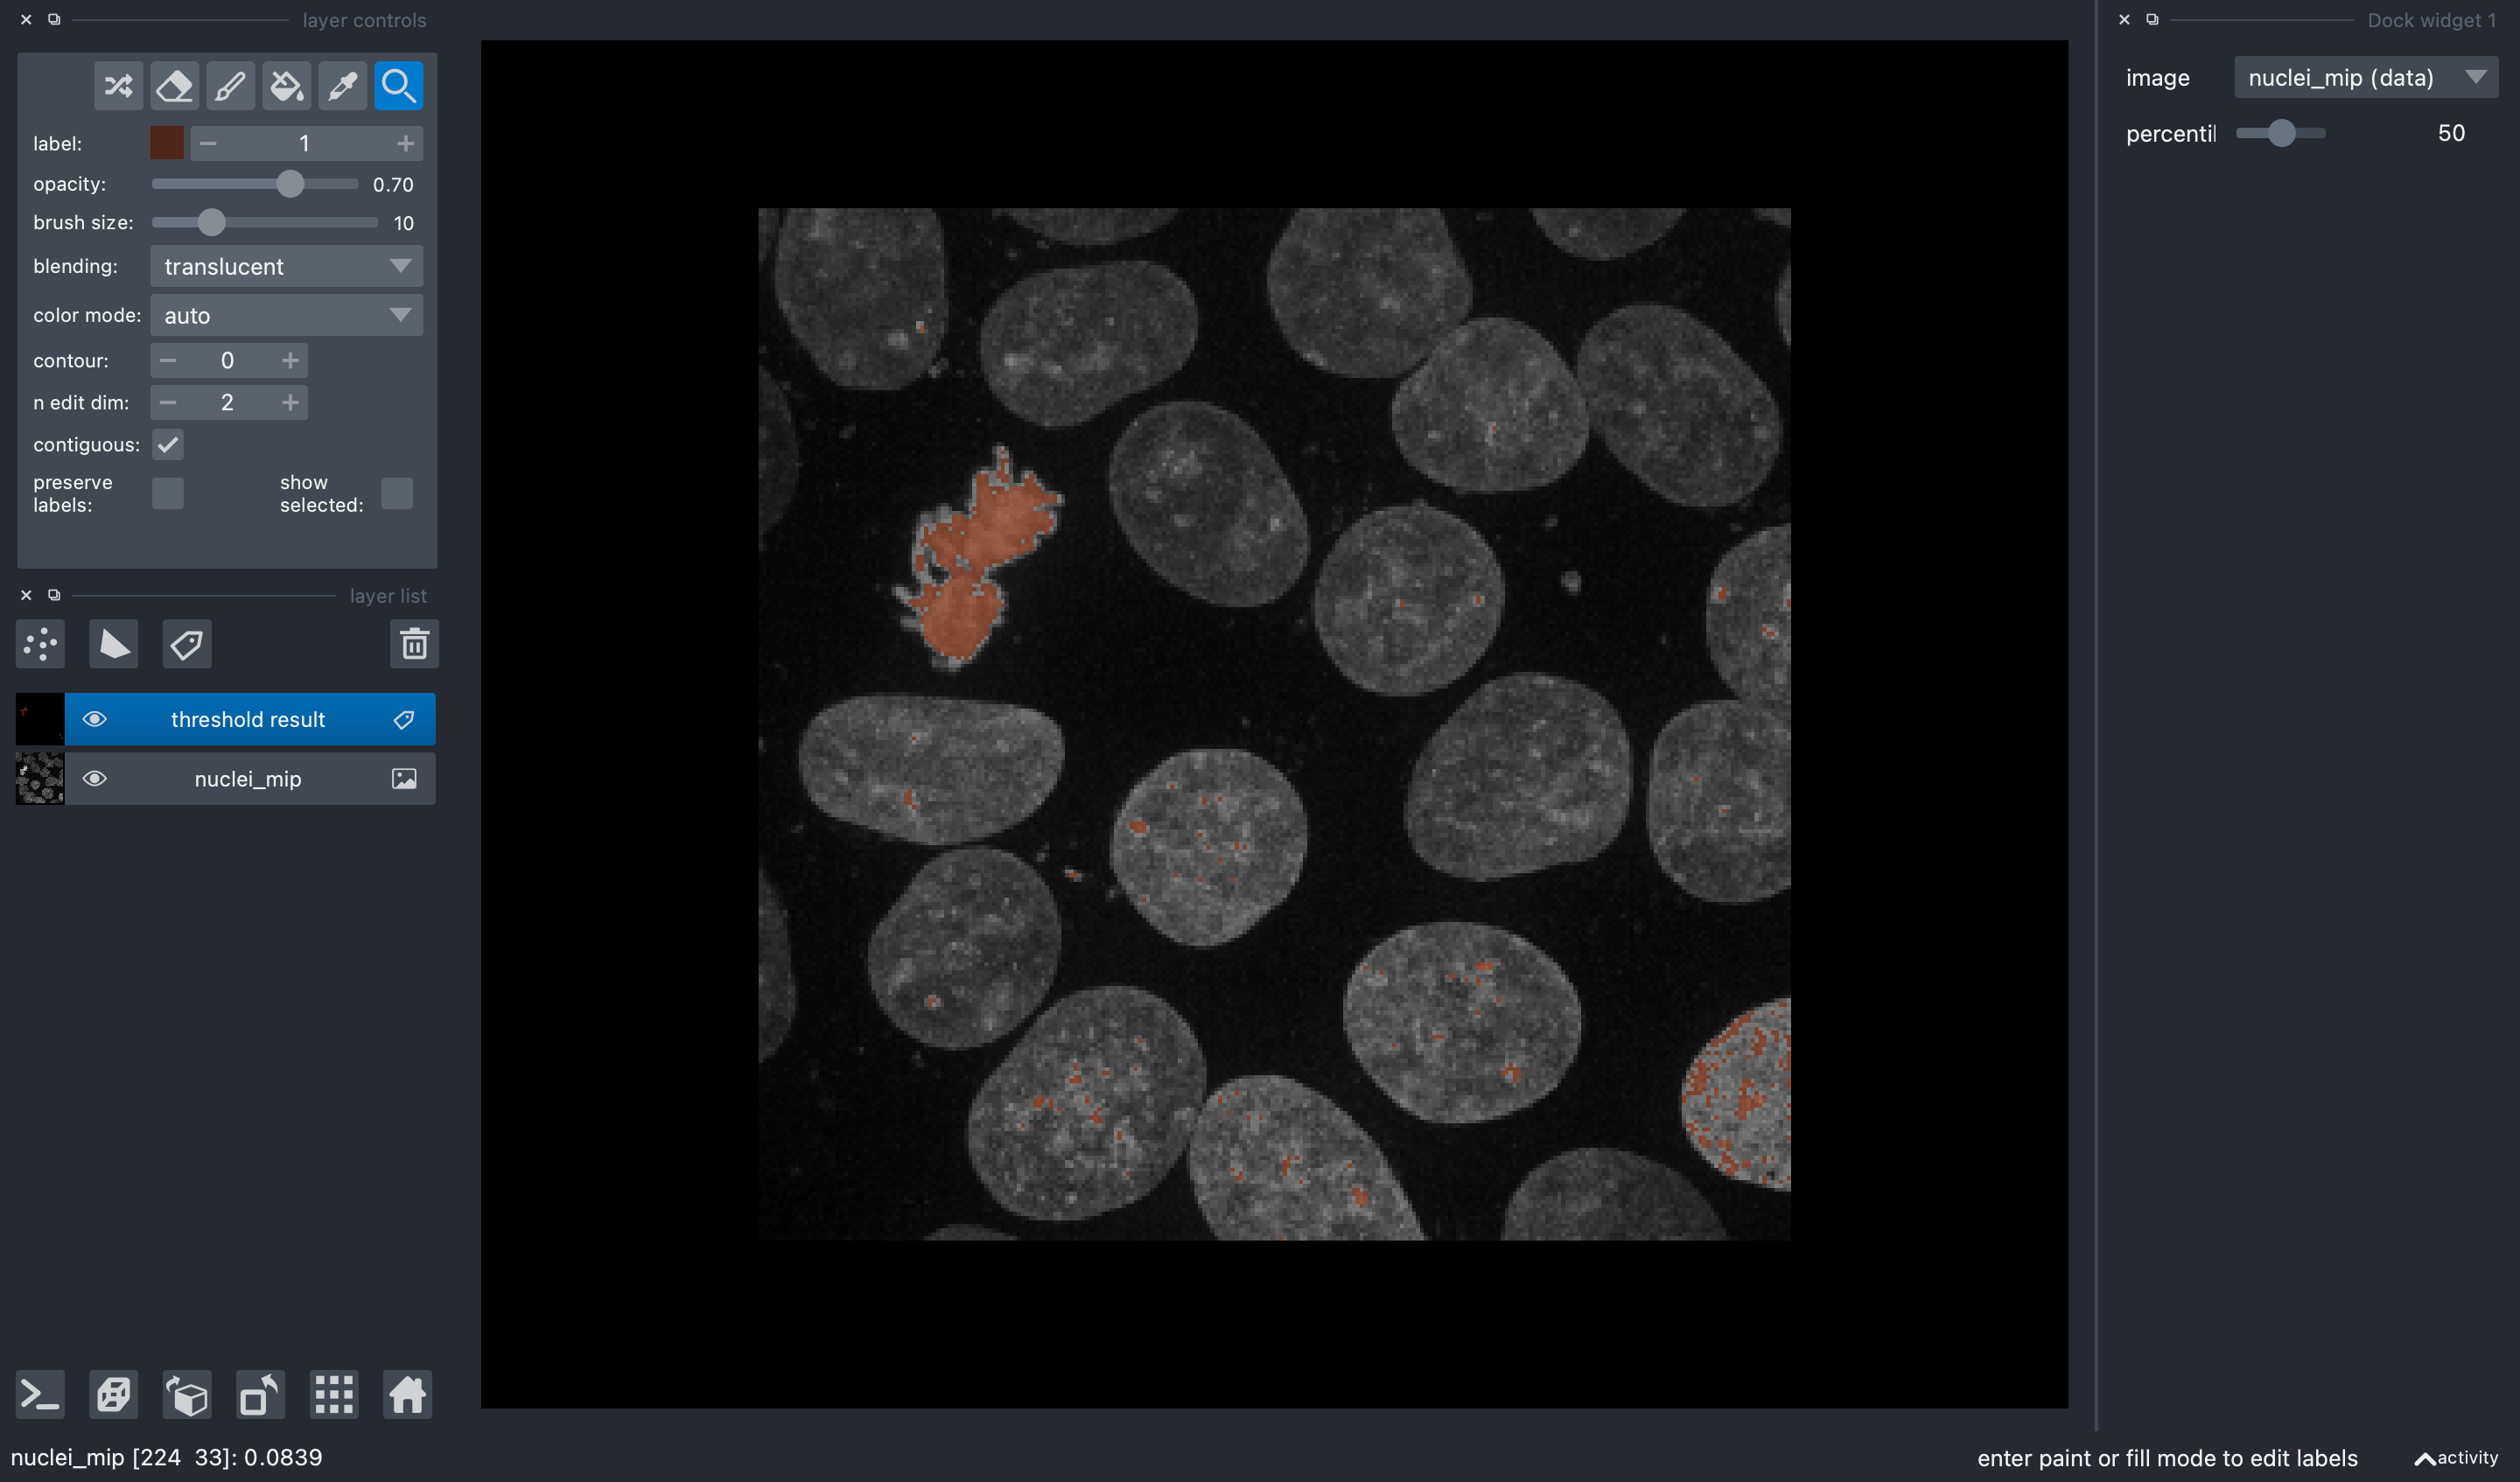

In [29]:
nbscreenshot(viewer)

## Adding a custom key binding to the viewer for processing foreground data

In [30]:
@viewer.bind_key('Shift-P')
def process_foreground(viewer):
    data = viewer.layers['threshold result'].data
    data_processed = morphology.remove_small_holes(data, 60)
    data_processed = morphology.remove_small_objects(data_processed, min_size=50)
    viewer.layers['threshold result'].data = data_processed

In [31]:
process_foreground(viewer)

<ipython-input-30-2eab8d4e1040>:4: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  data_processed = morphology.remove_small_holes(data, 60)


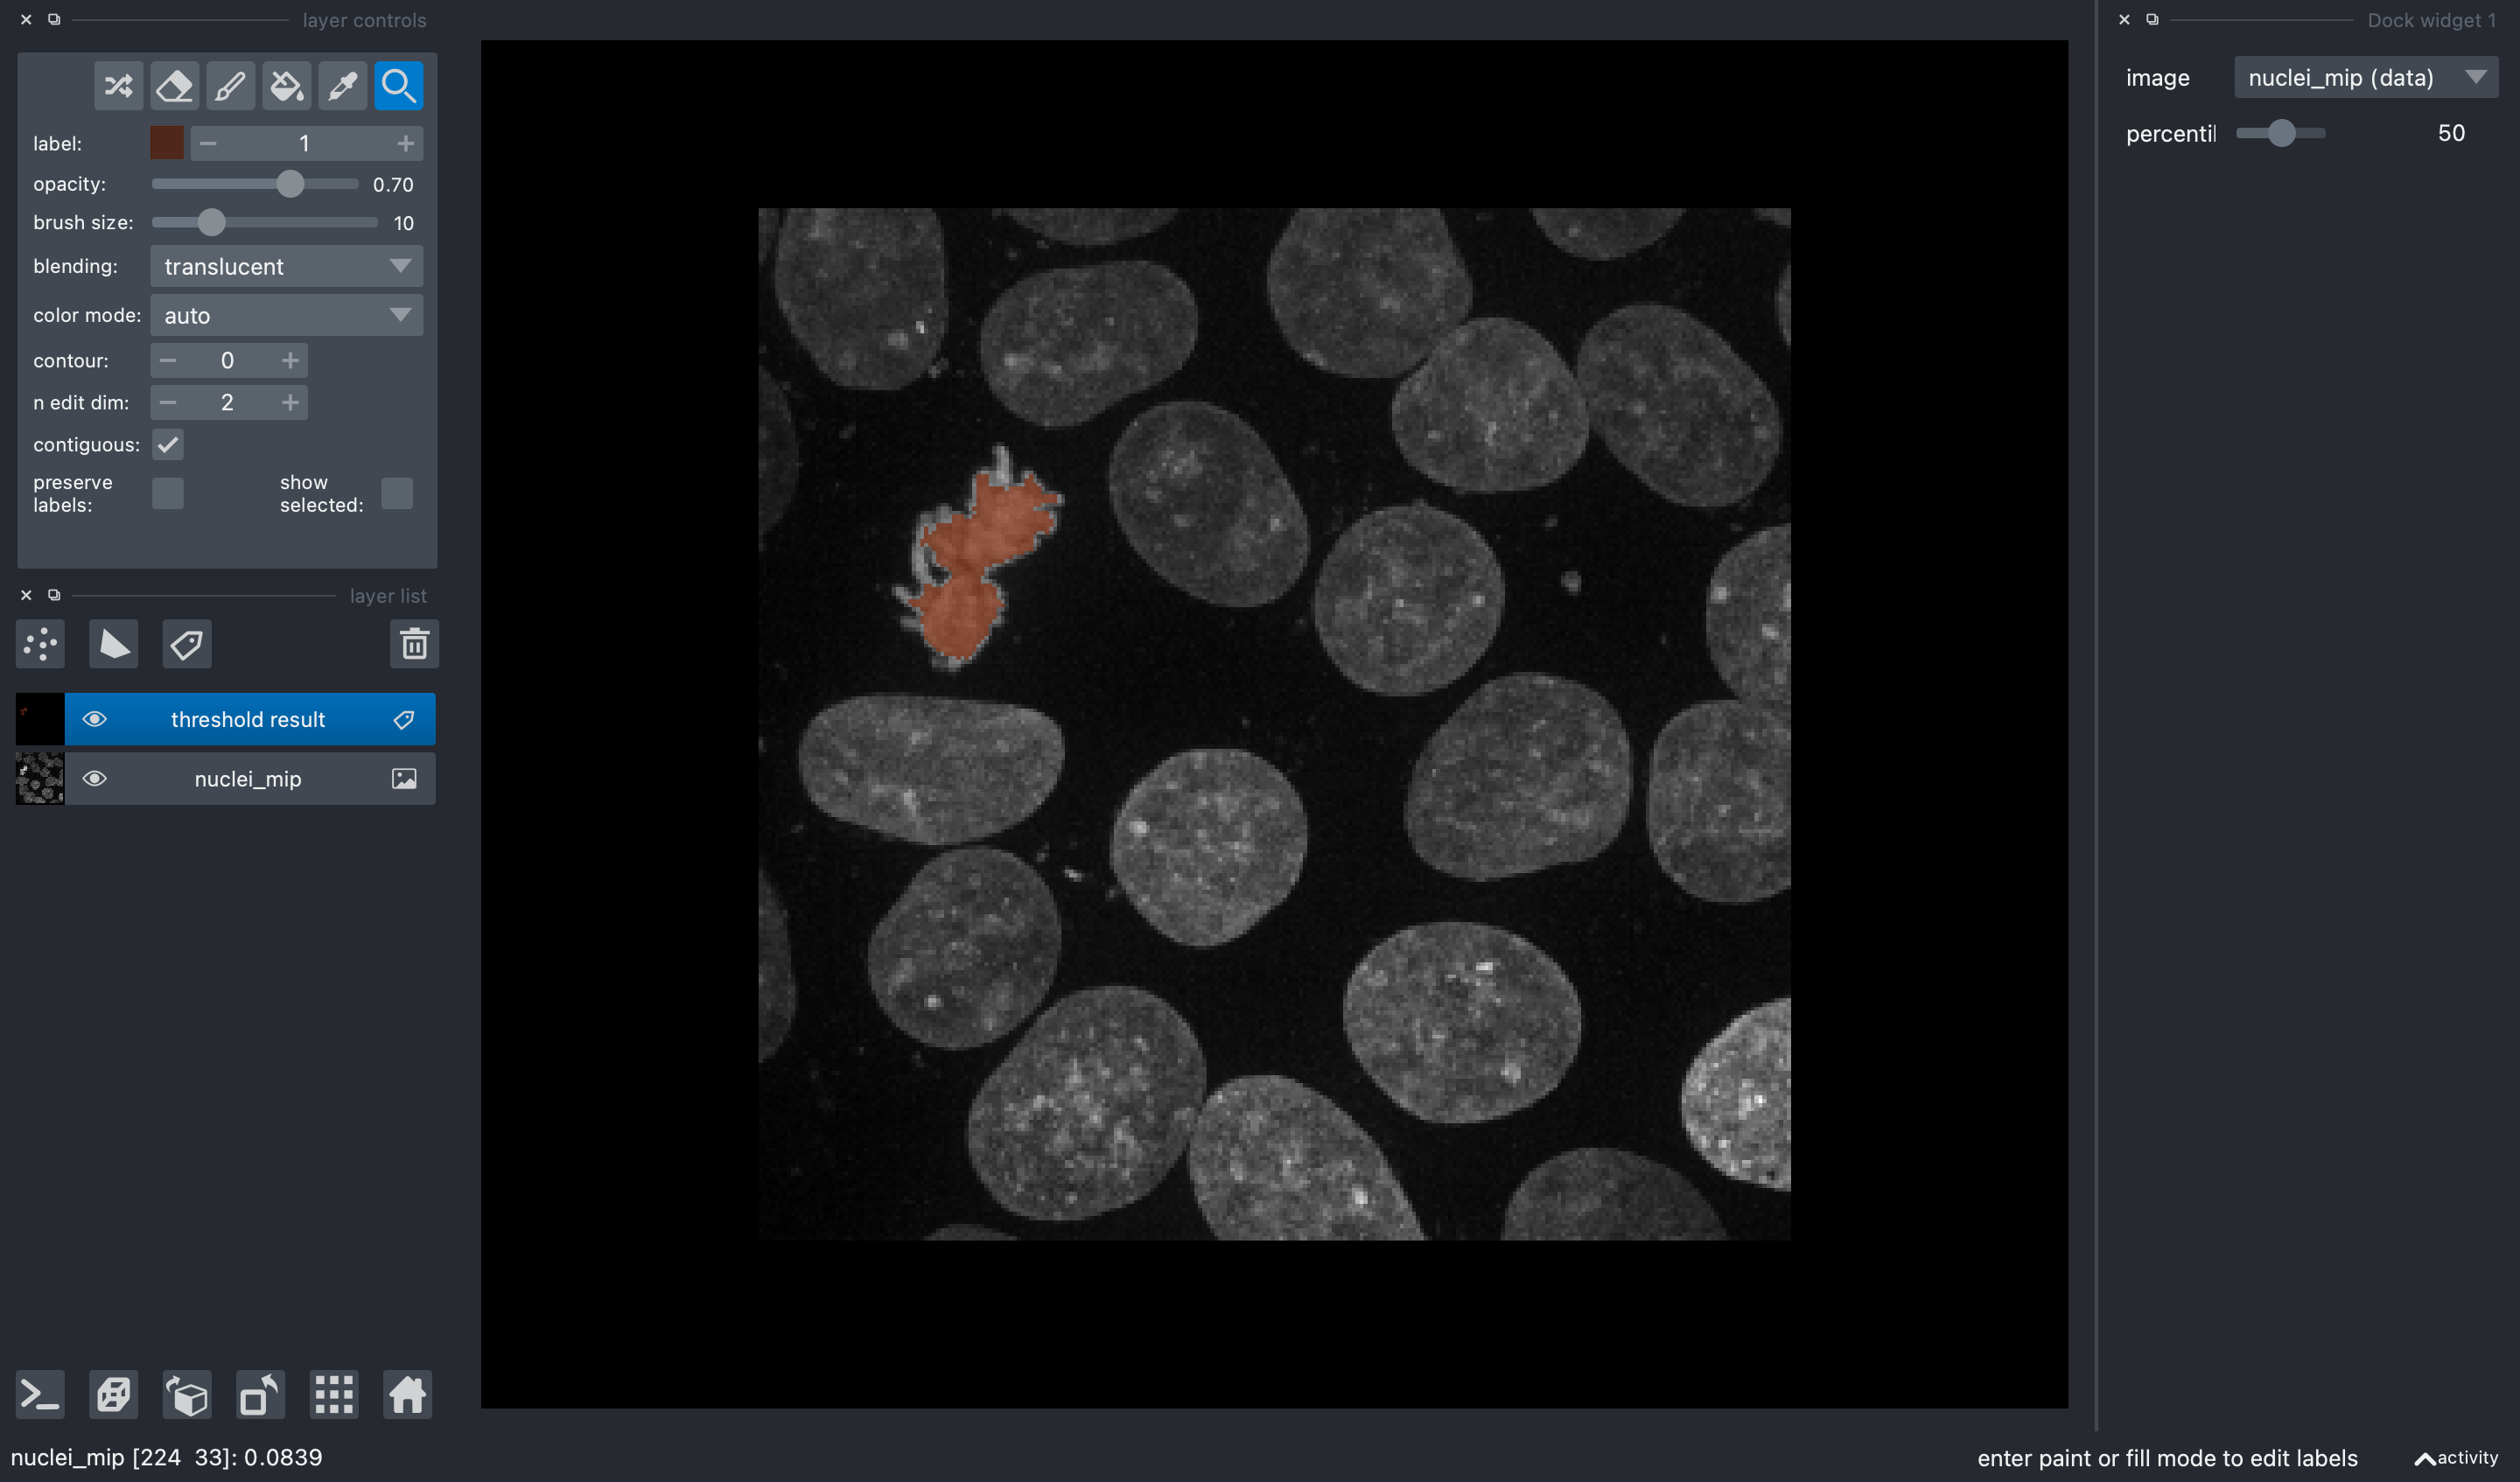

In [32]:
nbscreenshot(viewer)

In [33]:
# Add an empty labels layer with the same shape as our maximum intensity projection
viewer.add_labels(np.zeros(nuclei_mip.shape, dtype=int), name='nuclei segmentation')

<Labels layer 'nuclei segmentation' at 0x7f9c09ad9790>

In [34]:
# Bind another keybinding to complete segmentation
@viewer.bind_key('Shift-S')
def complete_segmentation(viewer):
    foreground = viewer.layers['threshold result'].data
    distance = ndimage.distance_transform_edt(foreground)
    smoothed_distance = filters.gaussian(distance, 10)
    peak_local_max = feature.peak_local_max(
        smoothed_distance,
        footprint=np.ones((7, 7), dtype=bool),
        indices=False,
        labels=measure.label(foreground)
    )
    peaks = np.nonzero(peak_local_max)
    seeds = np.zeros(smoothed_distance.shape, dtype=bool)
    seeds[(peaks[0], peaks[1])] = 1

    markers = measure.label(seeds)
    nuclei_segmentation = segmentation.watershed(
        -smoothed_distance, 
        markers, 
        mask=foreground
    )
    viewer.layers['nuclei segmentation'].data = nuclei_segmentation

In [35]:
image_data = viewer.layers['nuclei_mip'].data
thresholded = image_data > image_data.min() + 12 / 100 * (image_data.max() - image_data.min())
viewer.layers['threshold result'].data = thresholded
process_foreground(viewer)
complete_segmentation(viewer)

<ipython-input-30-2eab8d4e1040>:4: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  data_processed = morphology.remove_small_holes(data, 60)
<ipython-input-34-3203e3c58d90>:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_local_max = feature.peak_local_max(


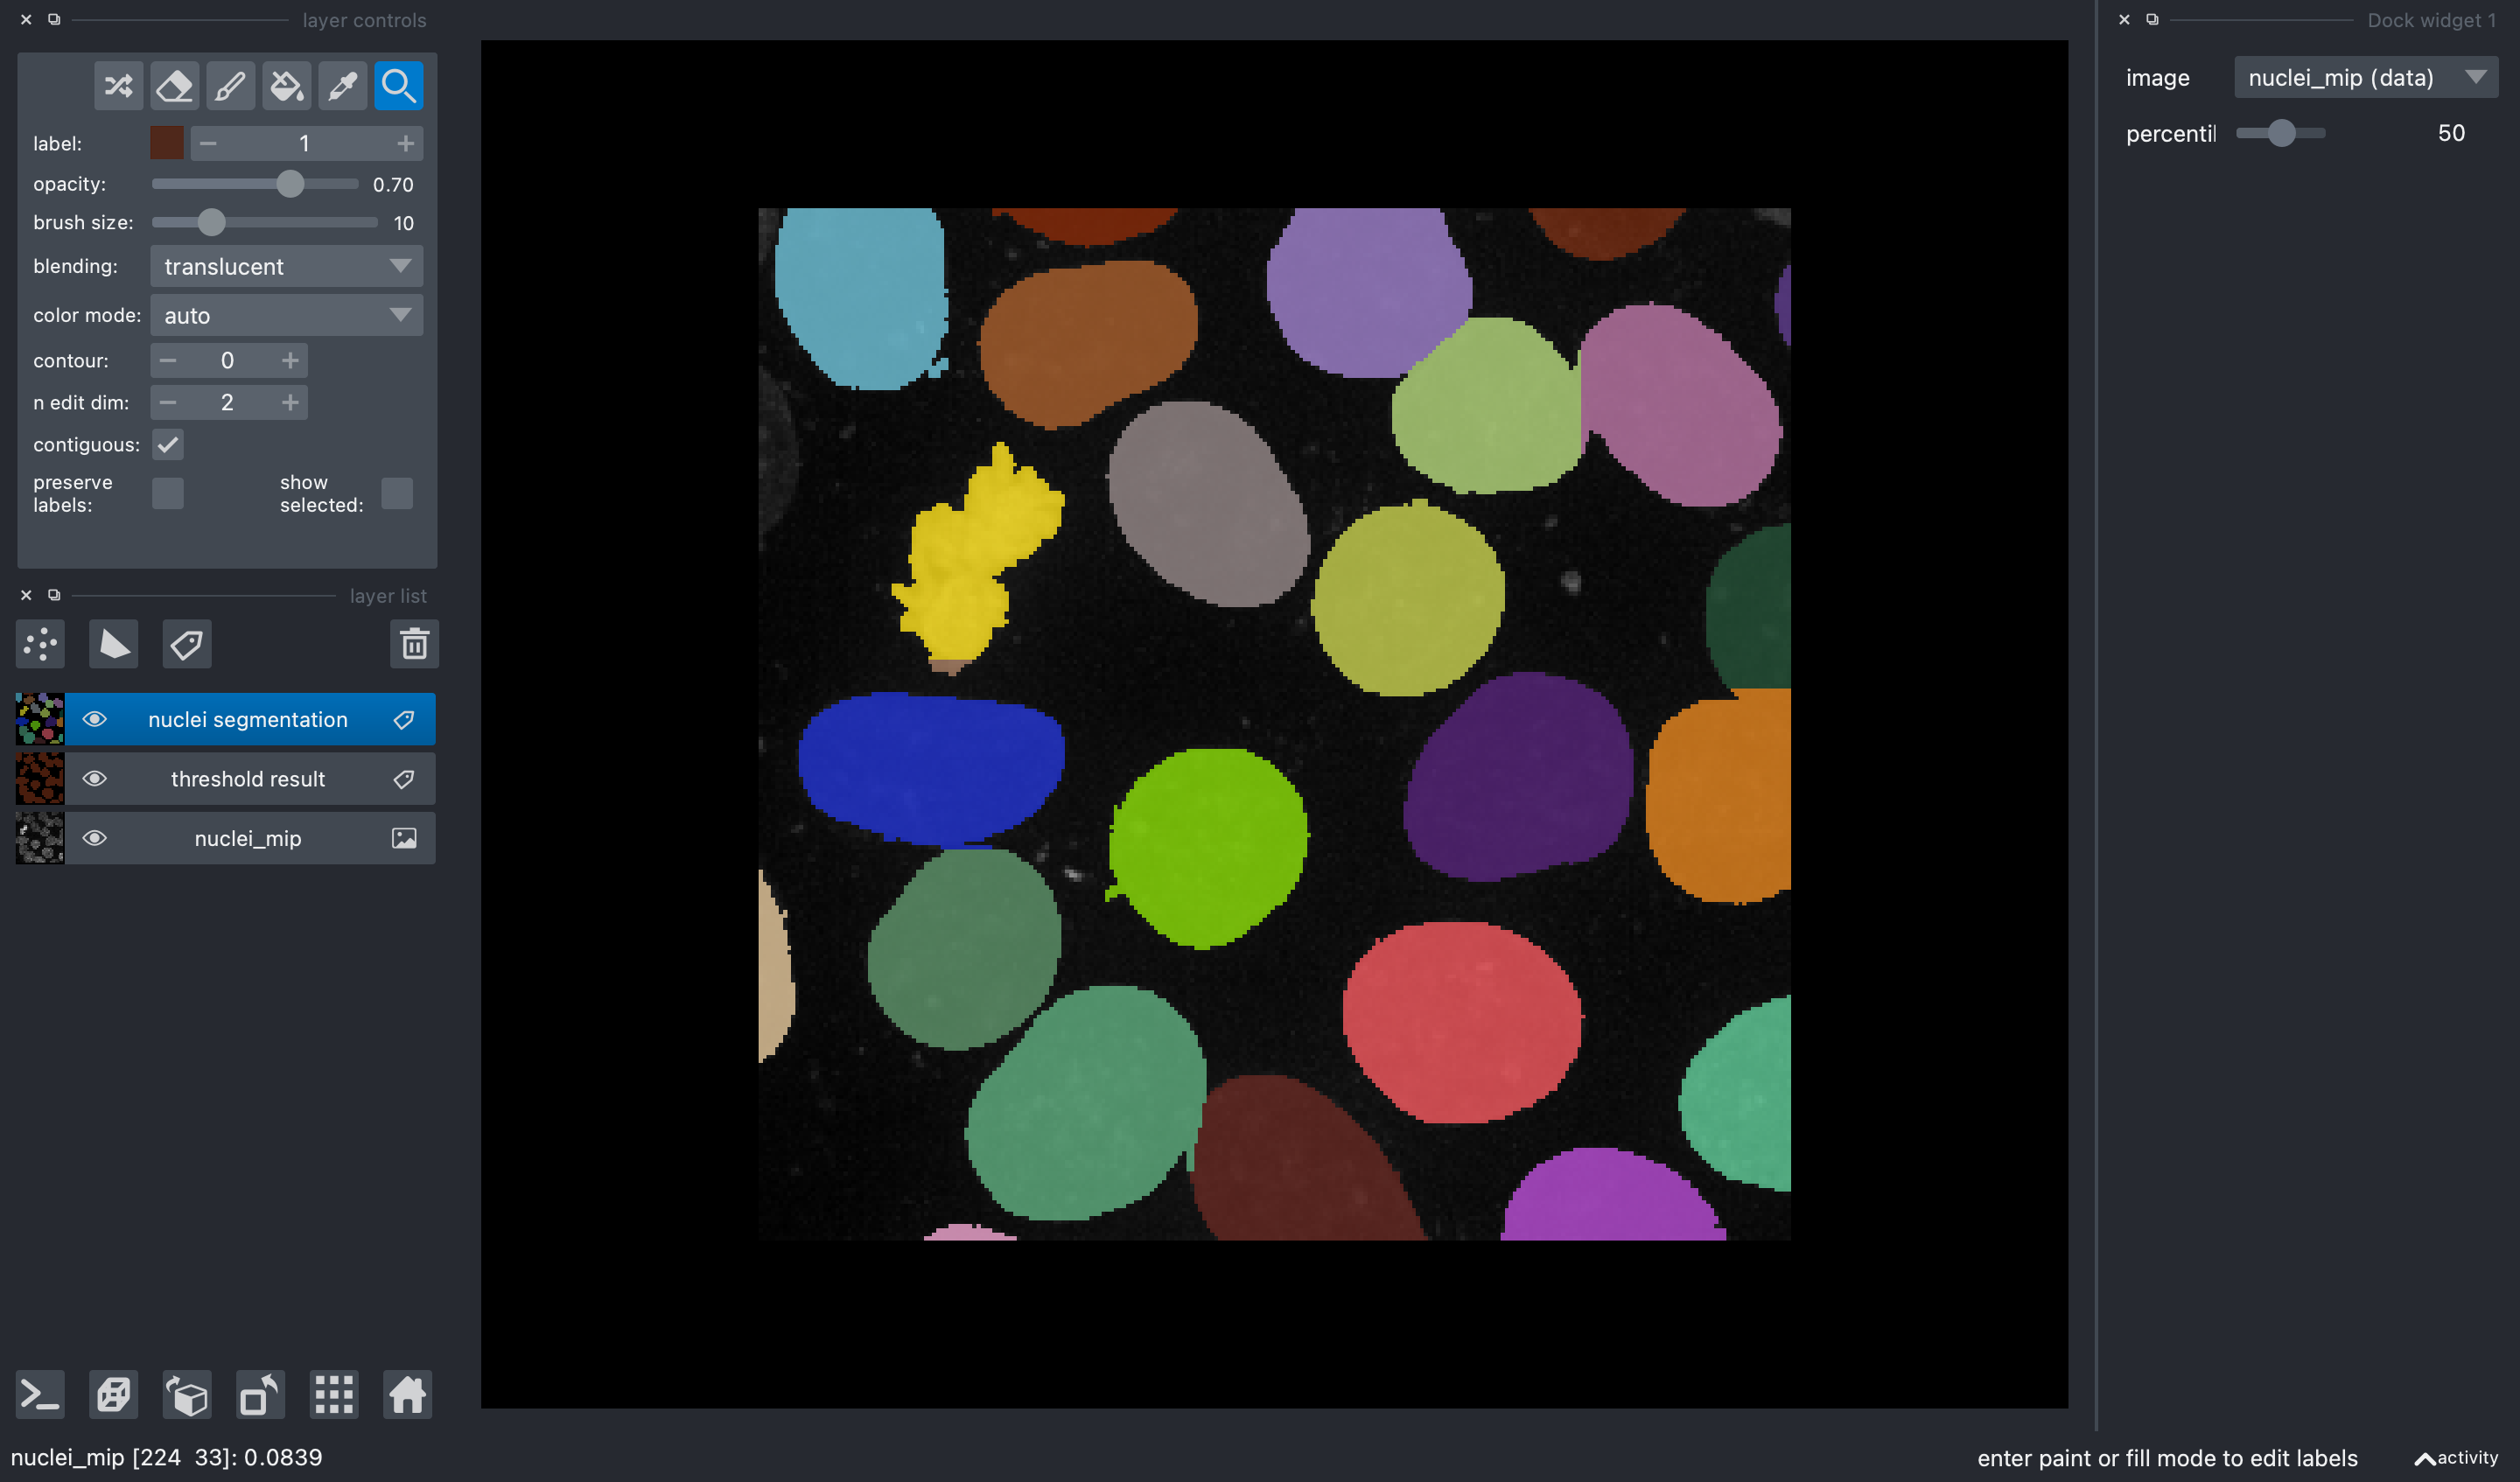

In [36]:
nbscreenshot(viewer)

## Conclusions

We've now seen how to interactively perform analyses by adding data to the napari viewer, and editing it as we moved through an analysis workflow. We've also seen how to extend the viewer with custom GUI functionality and keybindings, making analyses even more interactive!